In [36]:
# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
import tarfile
import urllib

# data visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# random seed to make output stable across runs
np.random.seed(42)

# data visualization
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [37]:
#Data loading

root = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
path = os.path.join("datasets", "housing")
source = root + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=source, path=path):
    if not os.path.isdir(path):
        os.makedirs(path)
    tgz_path = os.path.join(path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=path)
    housing_tgz.close()

fetch_housing_data()


def load_data(housing_path=path):
    csv = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv)

In [38]:
housing = load_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0    -122.23     37.88                41.0        880.0           129.0  \
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [39]:
####################################
######### DATA EXPLORATION #########
####################################

# check the data types of each column
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [40]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [42]:
type(housing.ocean_proximity[0])

str

With the `.info()` function we can already see elements of heterogeneity in the data.
• the feature `ocean_proximity` is not of type `float64` but are strings indicating one of these
options: `”<1h ocean”`, `”inland”`, `”near ocean”`, `”near bay”`, `”island”`
• the feature total bedrooms has 207 null values

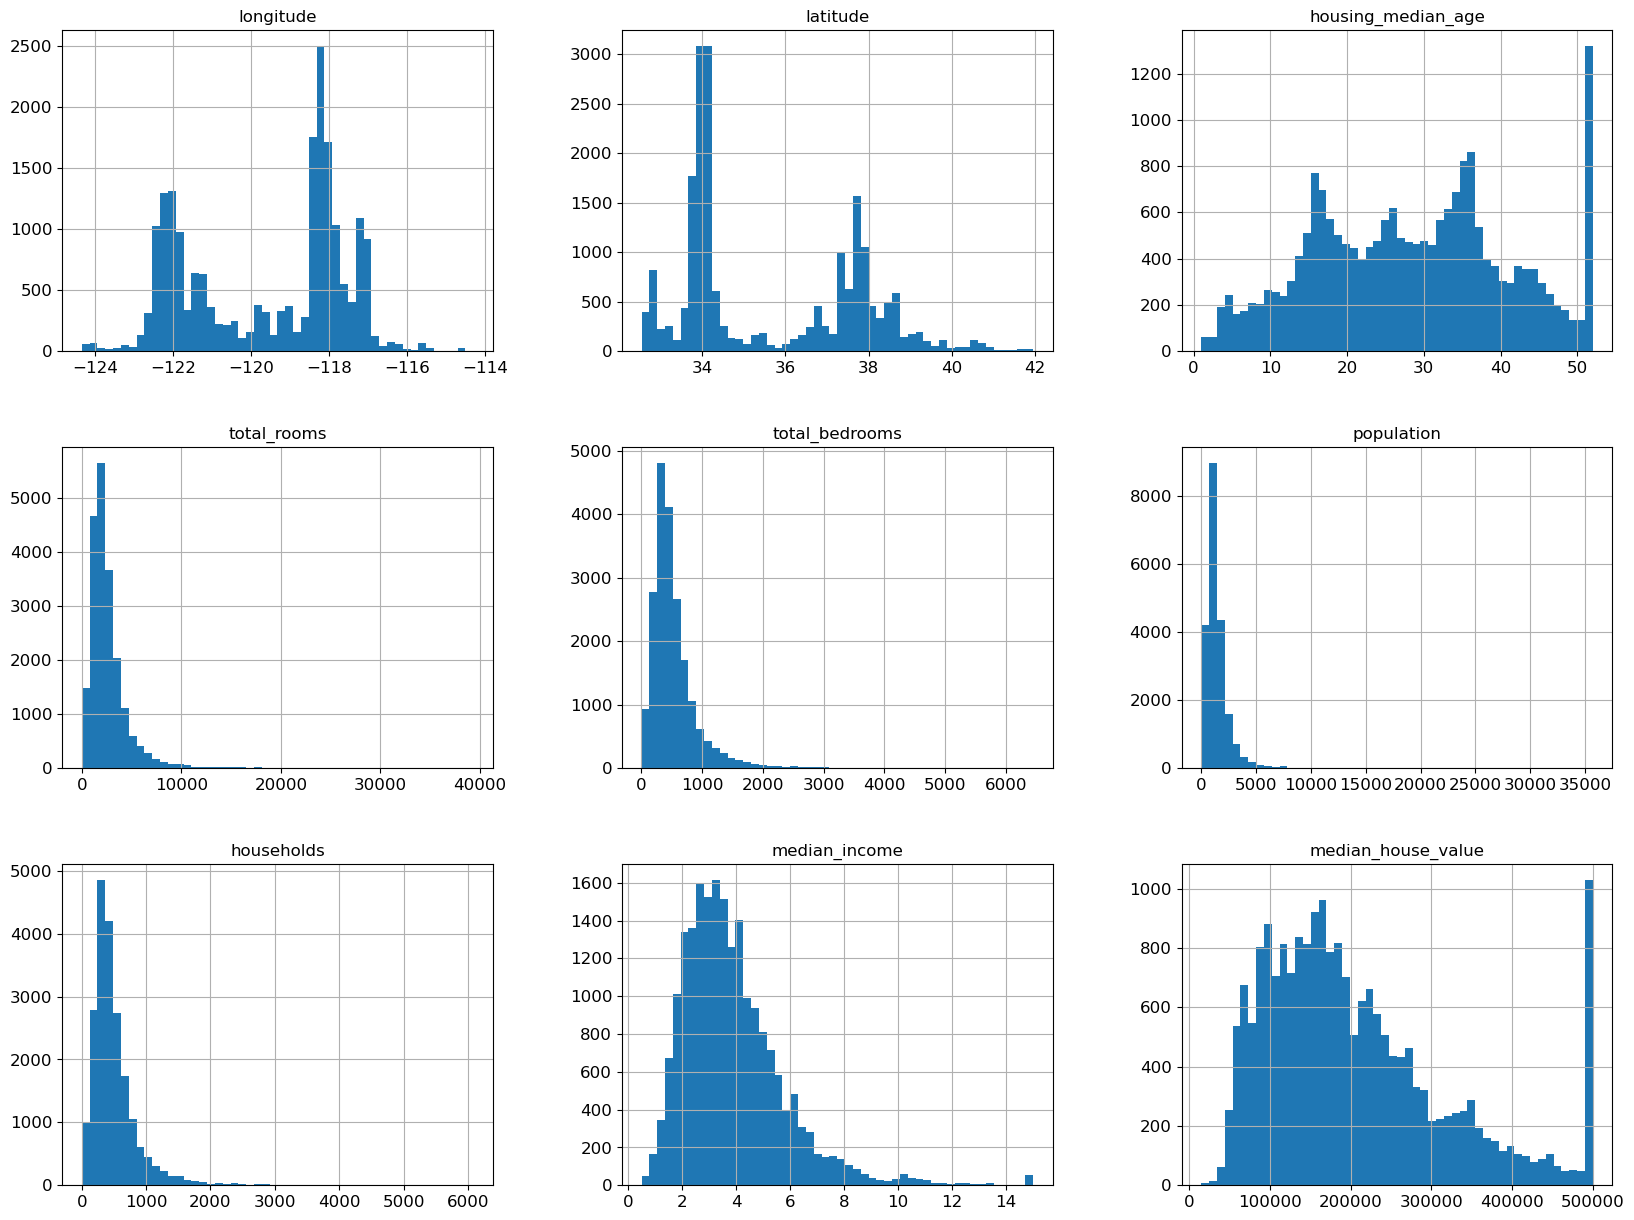

In [17]:


# check the number of unique values in each column
print("Number of unique values in each colunn: ",housing.nunique())

# check the number of missing values in each column
housing.isnull().sum()
print("Number of missing values in each column: ", housing.isnull().sum())


# check the distribution of numerical columns
housing.describe()


# plot the histogram of each numerical column
housing.hist(bins=50, figsize=(20,15))
plt.show()



We can notice that the meadian house value variable (our) target value has a slightly skewed gaussian distribution with the big exception of the values around 500k, which have a much higher value than according to the Gaussian 

We can see that many features have a quasi-gaussian distribution, possibly with some skewness on
the right side. Exceptions are the features in the first row of 8. Geographical features present both
two peaks, indicating two possible regions that are densely populated in California (which is indeed
the case looking at the simple plot here below) 

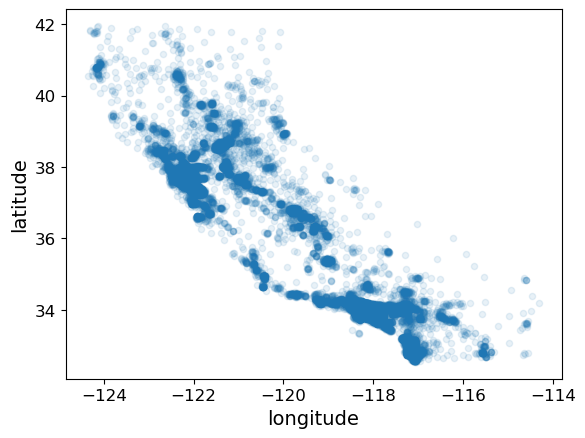

In [45]:
#create scatter points for the geographical data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

In [47]:
# take off the categorical column "NEAR BAY"
housing = housing.drop("ocean_proximity", axis=1)

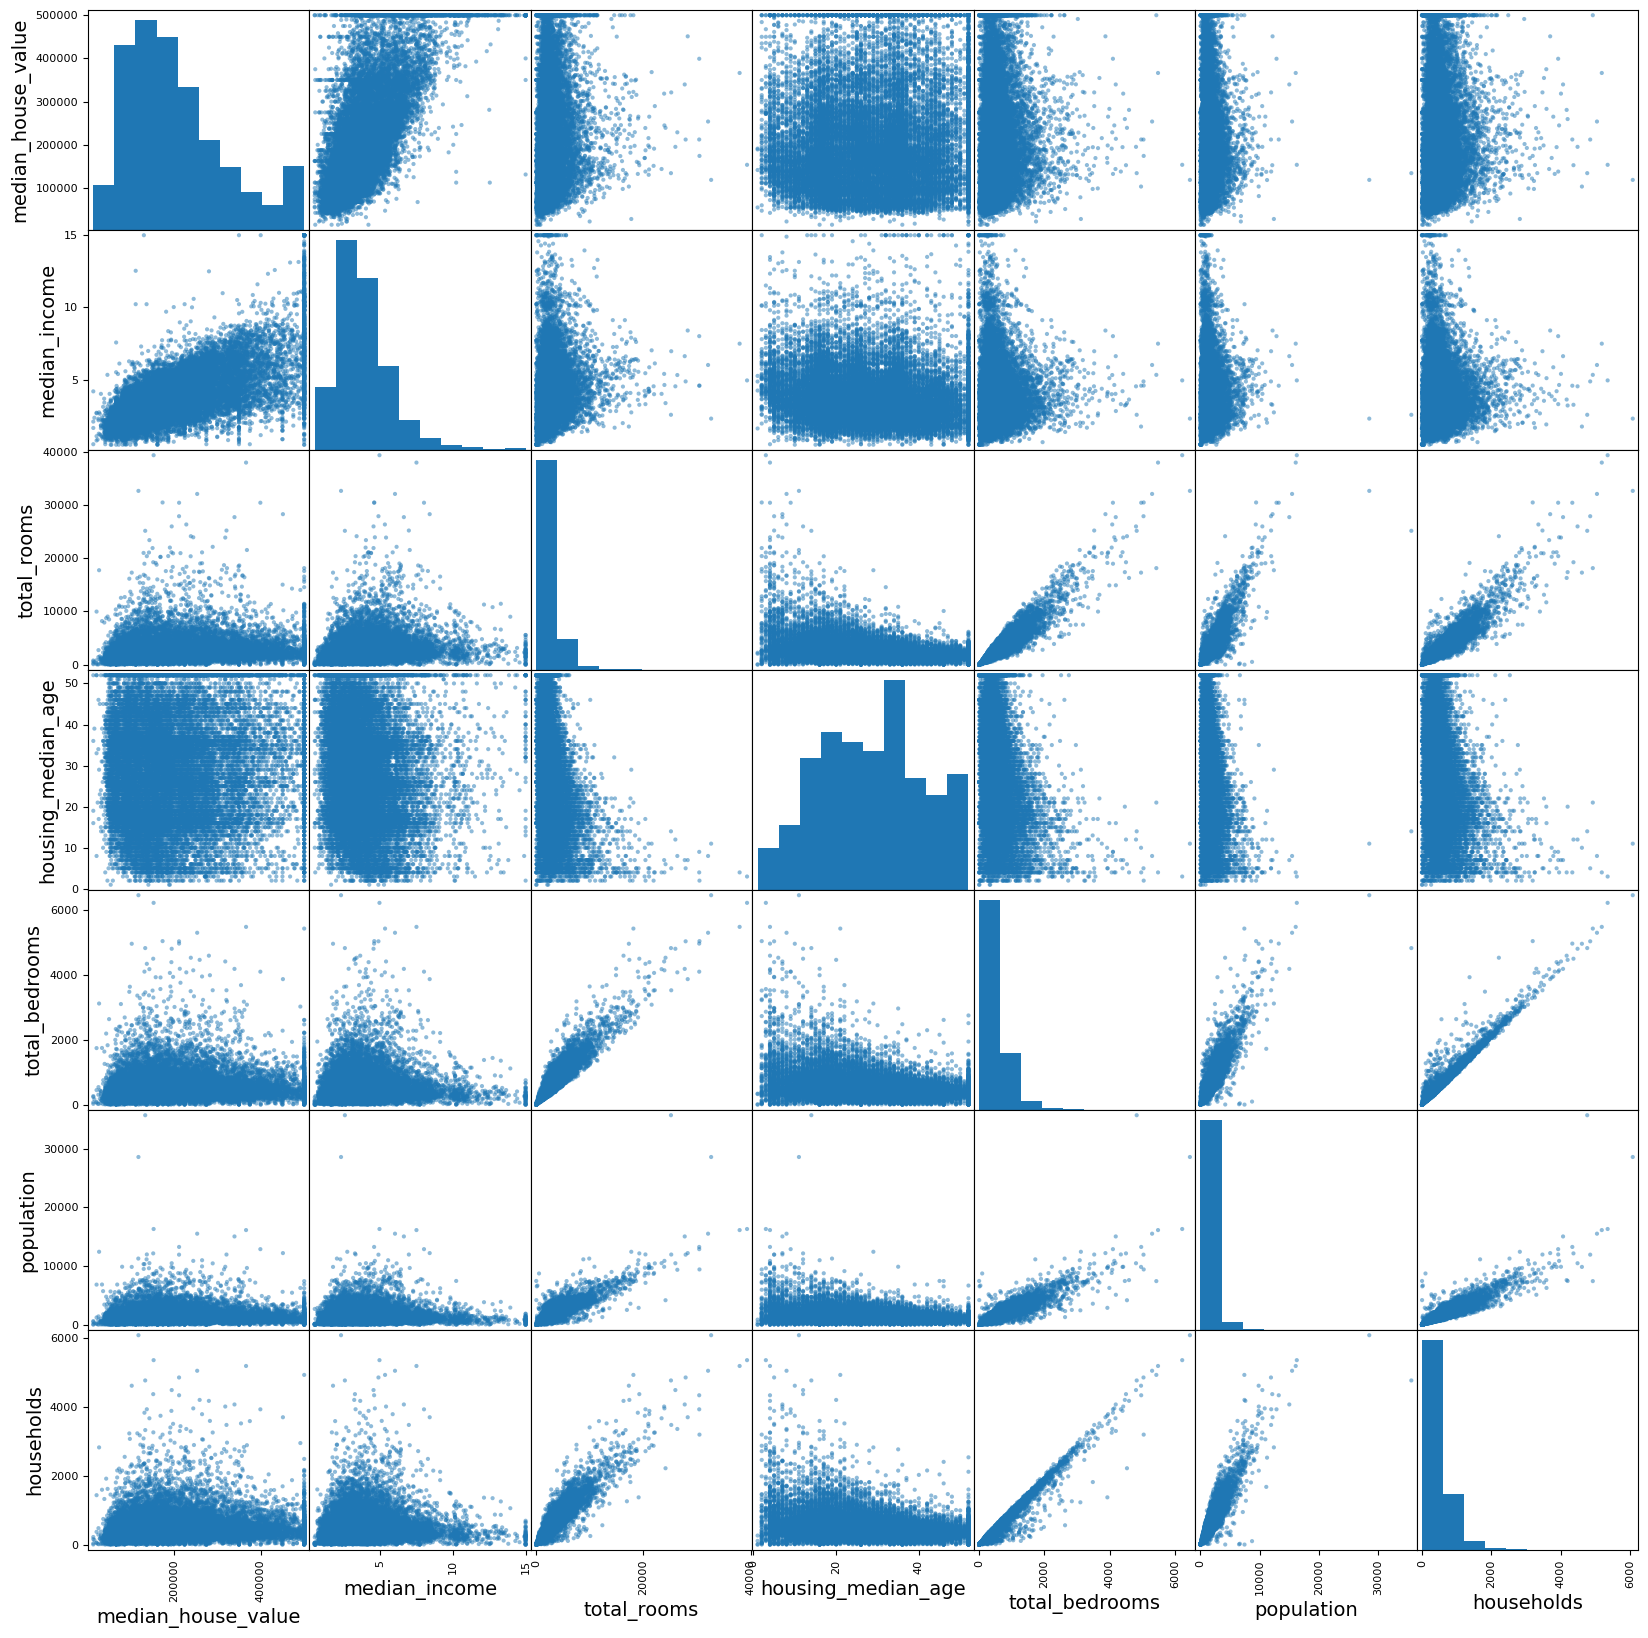

In [51]:
#create correlation plot between numerical columns except median_house_value
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age","total_bedrooms", "population", "households"]
scatter_matrix(housing[attributes], figsize=(20, 20))
plt.show()


Correlation plots also show that some features are very correlated (as expected I would say), such as total rooms and total bedrooms

----
I eliminated `ocean_proximity` because there is enough information to have good predictions using
a NN. I performed a dimensionality reduction with `t-SNE` of the data points taking out the target
variable. It seems that the z coordinate in the plot is partially correlated with the target variable,
therefore a neural network that is expressive enough would be able to catch this pattern

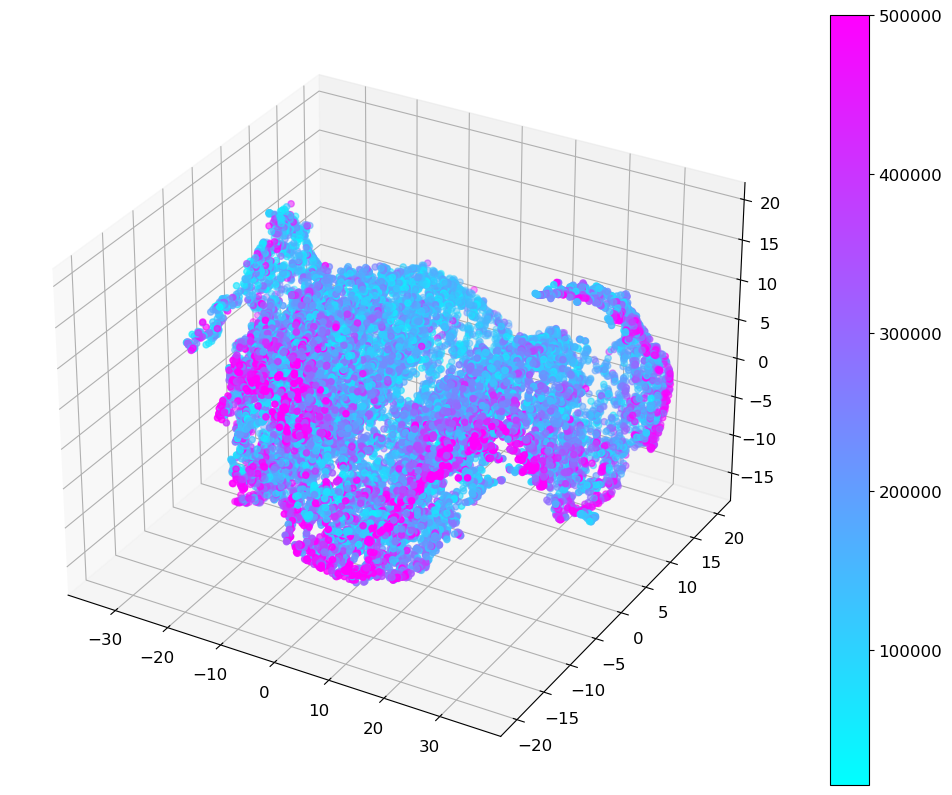

In [58]:
# We do a t-SNE plot to see if we can find any patterns in the data
from sklearn.manifold import TSNE

# deleate all the datapoints where nan appears
housing = housing.dropna()

# create dataset for t-SNE dropping the target column
housing_t_sne = housing.drop("median_house_value", axis=1)

tsne = TSNE(n_components=3, random_state=42)
housing_tsne = tsne.fit_transform(housing_t_sne)

# color the points depending on the median house value
# color the points depending on the median house value in a 3d scatter
plt.figure(figsize=(13, 10))
ax = plt.axes(projection="3d")
p = ax.scatter3D(
    housing_tsne[:, 0],
    housing_tsne[:, 1],
    housing_tsne[:, 2],
    c=housing["median_house_value"],
    cmap="cool",
)
plt.colorbar(p)
plt.show()


# The result of this plot is very clear, we can see that the median house value is higher
# the more we move on the right on this "curvilinear" manifold. An expressive enopuigh MLP
# should be able to capture this pattern.

In [73]:
#here we reload the data for simplicity
housing = load_data()

In [74]:
# you can eliminate the categorical variable "ocean_proximity" 

housing = housing.drop("ocean_proximity", axis=1)

To solve the second problem I used linear regression of the features `total rooms`, `households` and
`population` to predict the missing values of `total_bedrooms`, because these two features seemed to
be the three most correlated features with the latter form the pairwise correlation plot.

In [77]:
# use the households column to fill the nan values in the total_bedrooms column by regressing

from sklearn.linear_model import LinearRegression

# create a linear regression model
lin_reg = LinearRegression()

# create a dataset with the households + population +total rooms column and the total_bedrooms column
#concatenating the first three dataframes along columns
X = housing[["households", "population", "total_rooms"]]
y = housing["total_bedrooms"]

# eliminate the rows with missing values in y keeping track of the eliminated indices
# and then discard the corresponding rows in X
missing_values = y.isnull()
X = X[~missing_values]
y = y[~missing_values]

# # reshape the data so that it can be fed to the model
# X = X.values.reshape(-1, 1)
# y = y.values.reshape(-1, 1)

print("X shape: ", X.shape)
print("y shape: ", y.shape)

# fit the model
lin_reg.fit(X, y)

# predict the total_bedrooms column where there are missing values
predicted_values = lin_reg.predict(housing[["households", "population", "total_rooms"]])

# convert the predicted values array back to a pandas Series
predicted_series = pd.Series(predicted_values.flatten(), index=housing.index)

# fill the missing values in the total_bedrooms column
housing["total_bedrooms"] = housing["total_bedrooms"].fillna(predicted_series)

# check if there are still missing values
print("Number of missing values in each column: \n", housing.isnull().sum())

X shape:  (20433, 3)
y shape:  (20433,)
Number of missing values in each column: 
 longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64


In [79]:
housing

longitude  latitude  housing_median_age  total_rooms  total_bedrooms   
0        -122.23     37.88                41.0        880.0           129.0  \
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  
0           322.0       126.0         8.3252            452600.0  
1          2401.0      1138.0         8.3014            358500.0  
2           496.0       177.0         7.2574            352100.0  
3           558.0       219.0         5.6431            341300.0  
4           565.0       259.0         3.8462            342200.0  
...           ...         ...            ...                 ...  
20635       845.0       330.0         1.5603             78100.0  
20636       356.0       114.0         2.5568             77100.0  
20637      1007.0       433.0         1.7000             92300.0  
20638       741.0       349.0         1.8672             84700.0  
20639      1387.0       530.0         2.3886             89400.0  

[20640 rows x 9 columns]

 ##### Training the model with num layers 5, neurons per layer 10, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.609375
Epoch 100, loss 237267.328125
Epoch 200, loss 236585.0
Epoch 300, loss 214858.140625
Epoch 400, loss 139365.125
Epoch 500, loss 109846.4375
Epoch 600, loss 100609.1640625
Epoch 700, loss 94638.765625
Epoch 800, loss 89646.8671875
Epoch 900, loss 85212.8828125
Epoch 1000, loss 81218.40625
Epoch 1100, loss 77500.8515625
Epoch 1200, loss 74270.4375
Epoch 1300, loss 71884.734375
Epoch 1400, loss 70218.859375
Epoch 1500, loss 69069.4765625
Epoch 1600, loss 68254.5625
Epoch 1700, loss 67650.9296875
Epoch 1800, loss 67194.984375
Epoch 1900, loss 66841.6875
Epoch 2000, loss 66559.390625
Epoch 2100, loss 66327.171875
Epoch 2200, loss 66056.3515625
Epoch 2300, loss 65820.7734375
Epoch 2400, loss 65358.41796875
Epoch 2500, loss 64897.46484375
Epoch 2600, loss 64463.95703125
Epoch 2700, loss 64070.30078125
Epoch 2800, loss 63735.5546875
Epoch 2900, loss 634

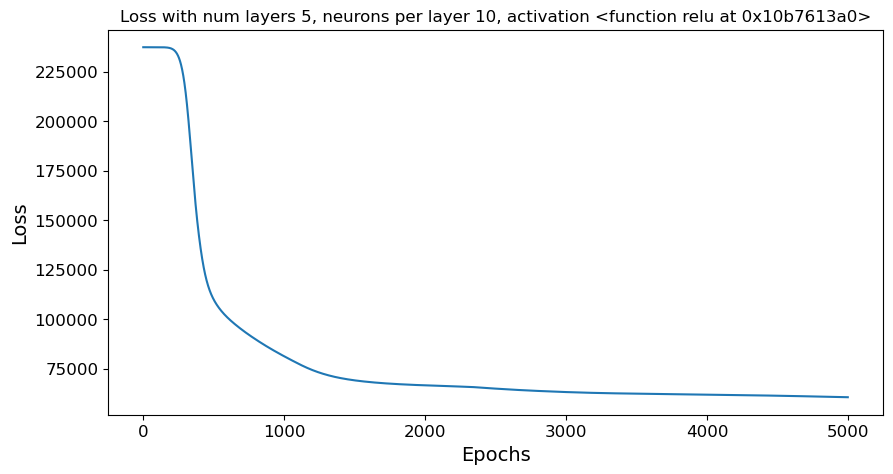

RMSE: 60515.953125 




60515.953125

In [82]:
####################################
########## MODEL TRAINING #########
####################################

# We want to implement neural network models in PyTorch for regression tasks, exploring various architectures and hyperparameters.


# We start by splitting the data into training and testing sets
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# We convert the data to PyTorch tensors
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)


# We define the neural network model with custom number of layers given as an int,
# neuron per layer and activation functions

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, neurons_per_layer, activation):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.activation = activation

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.input_size, self.neurons_per_layer))
        for i in range(self.hidden_layers):
            self.layers.append(nn.Linear(self.neurons_per_layer, self.neurons_per_layer))
        self.layers.append(nn.Linear(self.neurons_per_layer, self.output_size))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x


# We define the training function and plot the loss after the training
# by saving each loss value in a list and plotting it at the end and
# printing the loss every 100 epochs
def train(model, X_train, y_train, epochs, lr):
    print(
        f" ##### Training the model with num layers {model.hidden_layers}, neurons per layer {model.neurons_per_layer}, activation {model.activation} #####"
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)

        # Ensure that y_pred and y_train have the same shape
        y_pred = y_pred.squeeze(-1)
        y_train = y_train.squeeze(-1)

        loss = torch.sqrt(criterion(y_pred, y_train))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")

    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(
        f"Loss with num layers {model.hidden_layers}, neurons per layer {model.neurons_per_layer}, activation {model.activation}"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


# We define the evaluation function
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        #check if in X_test there are any nan values
        y_pred = model(X_test)
        loss = torch.sqrt(nn.MSELoss()(y_pred, y_test))
        print(f'RMSE: {loss.item()}', '\n\n')
        return loss.item()

# We define the model parameters
input_size = X_train_tensor.shape[1]
output_size = 1
hidden_layers = 5
neurons_per_layer = 10
activation = F.relu
epochs = 5000
lr = 0.001

# We train the model
model = MLP(input_size, output_size, hidden_layers, neurons_per_layer, activation)
train(model, X_train_tensor, y_train_tensor, epochs, lr)

# We evaluate the model
evaluate(model, X_test_tensor, y_test_tensor)

 ##### Training the model with num layers 1, neurons per layer 50, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.859375
Epoch 100, loss 237248.59375
Epoch 200, loss 237059.03125
Epoch 300, loss 236458.25
Epoch 400, loss 235211.140625
Epoch 500, loss 233117.65625
Epoch 600, loss 230018.0
Epoch 700, loss 225793.984375
Epoch 800, loss 220369.609375
Epoch 900, loss 213660.5625


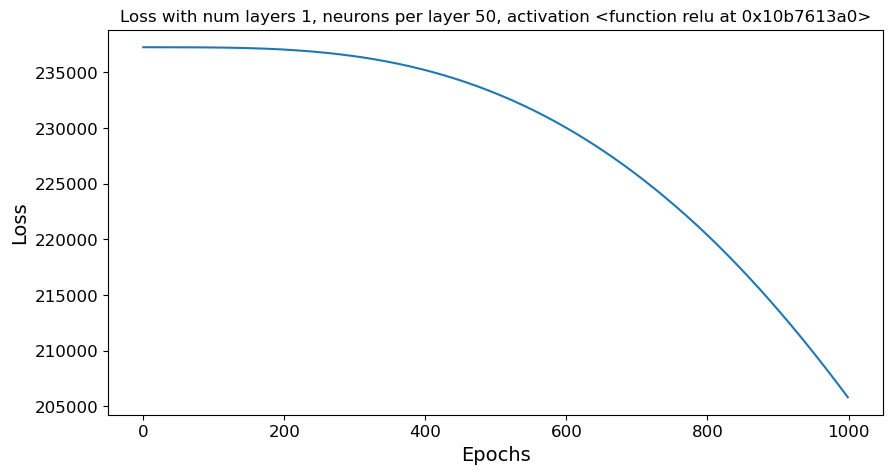

RMSE: 209751.90625 


 ##### Training the model with num layers 1, neurons per layer 50, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.390625
Epoch 100, loss 237265.546875
Epoch 200, loss 237260.78125
Epoch 300, loss 237256.09375
Epoch 400, loss 237250.84375
Epoch 500, loss 237245.4375
Epoch 600, loss 237240.40625
Epoch 700, loss 237235.53125
Epoch 800, loss 237230.78125
Epoch 900, loss 237226.09375


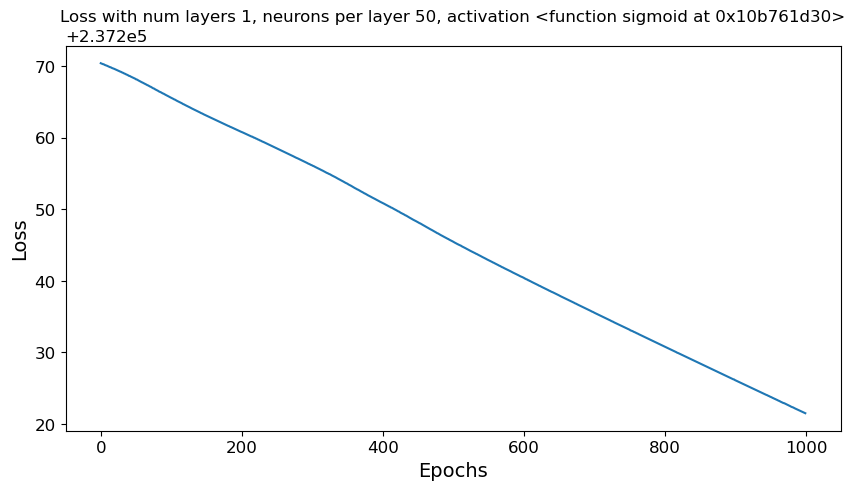

RMSE: 235183.453125 


 ##### Training the model with num layers 1, neurons per layer 50, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.78125
Epoch 100, loss 237263.484375
Epoch 200, loss 237256.515625
Epoch 300, loss 237251.171875
Epoch 400, loss 237246.171875
Epoch 500, loss 237241.359375
Epoch 600, loss 237236.609375
Epoch 700, loss 237231.953125
Epoch 800, loss 237227.3125
Epoch 900, loss 237222.71875


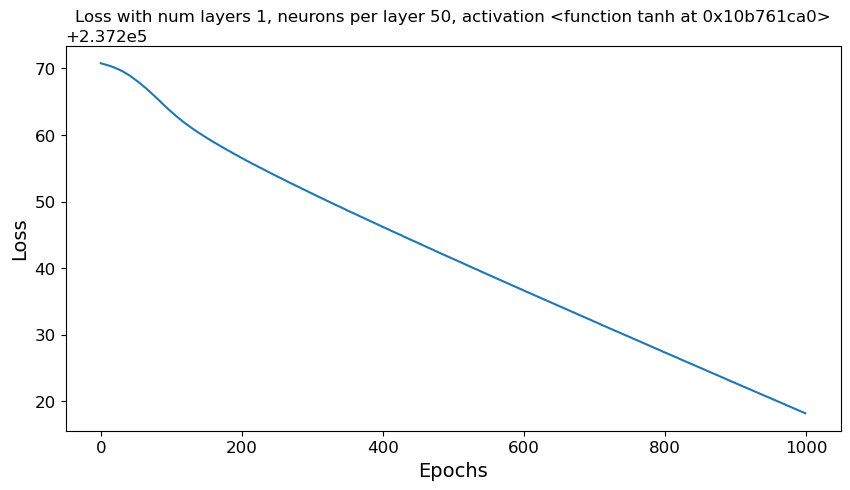

RMSE: 235180.109375 


 ##### Training the model with num layers 1, neurons per layer 100, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.859375
Epoch 100, loss 237200.703125
Epoch 200, loss 236565.1875
Epoch 300, loss 234523.015625
Epoch 400, loss 230256.75
Epoch 500, loss 223141.203125
Epoch 600, loss 212789.15625
Epoch 700, loss 199059.453125
Epoch 800, loss 182155.40625
Epoch 900, loss 162795.15625


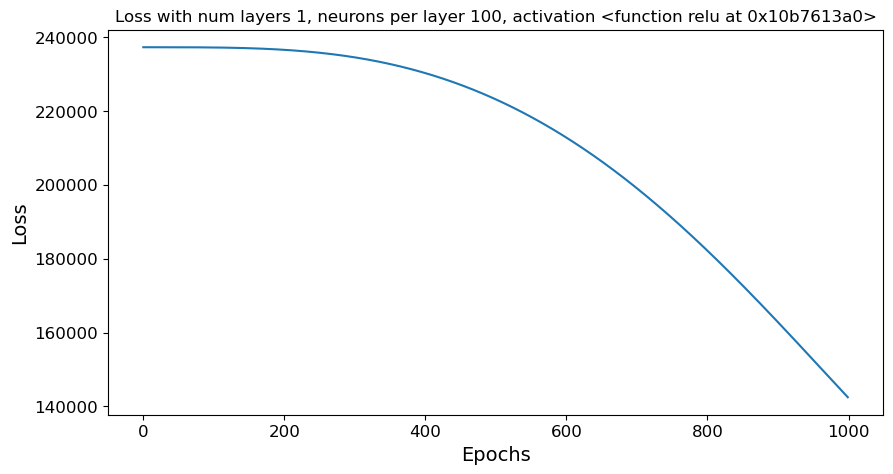

RMSE: 168490.578125 


 ##### Training the model with num layers 1, neurons per layer 100, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.03125
Epoch 100, loss 237263.109375
Epoch 200, loss 237254.703125
Epoch 300, loss 237245.0625
Epoch 400, loss 237235.109375
Epoch 500, loss 237225.078125
Epoch 600, loss 237215.5
Epoch 700, loss 237205.734375
Epoch 800, loss 237195.421875
Epoch 900, loss 237185.703125


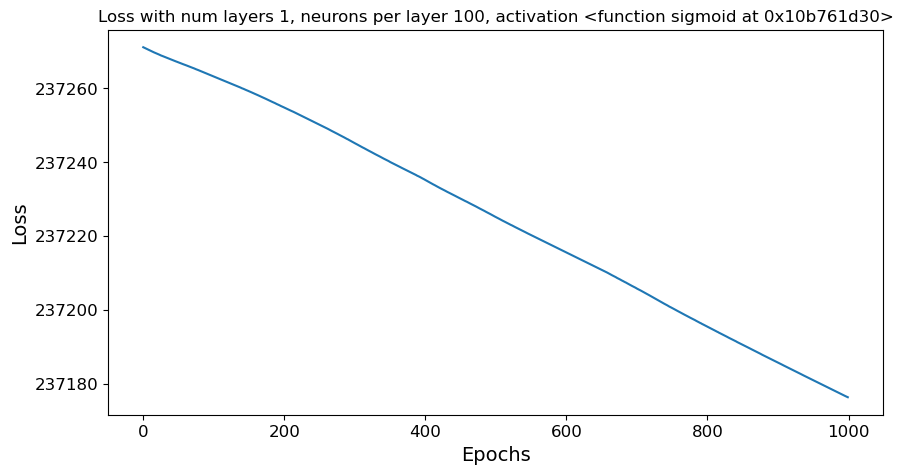

RMSE: 235138.21875 


 ##### Training the model with num layers 1, neurons per layer 100, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 237255.890625
Epoch 200, loss 237244.890625
Epoch 300, loss 237235.046875
Epoch 400, loss 237225.609375
Epoch 500, loss 237216.34375
Epoch 600, loss 237207.1875
Epoch 700, loss 237198.09375
Epoch 800, loss 237189.0625
Epoch 900, loss 237180.046875


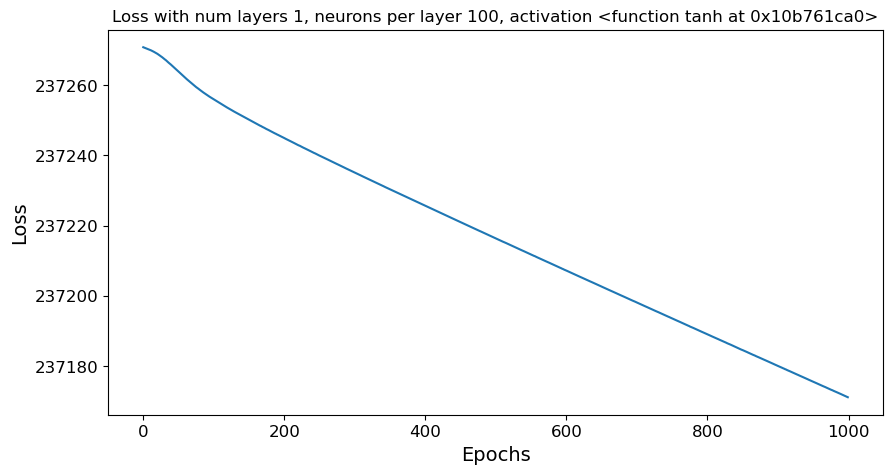

RMSE: 235133.046875 


 ##### Training the model with num layers 1, neurons per layer 200, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.765625
Epoch 100, loss 236983.0625
Epoch 200, loss 234390.03125
Epoch 300, loss 226258.46875
Epoch 400, loss 209992.984375
Epoch 500, loss 184741.40625
Epoch 600, loss 152587.34375
Epoch 700, loss 119543.1953125
Epoch 800, loss 99784.578125
Epoch 900, loss 92700.4296875


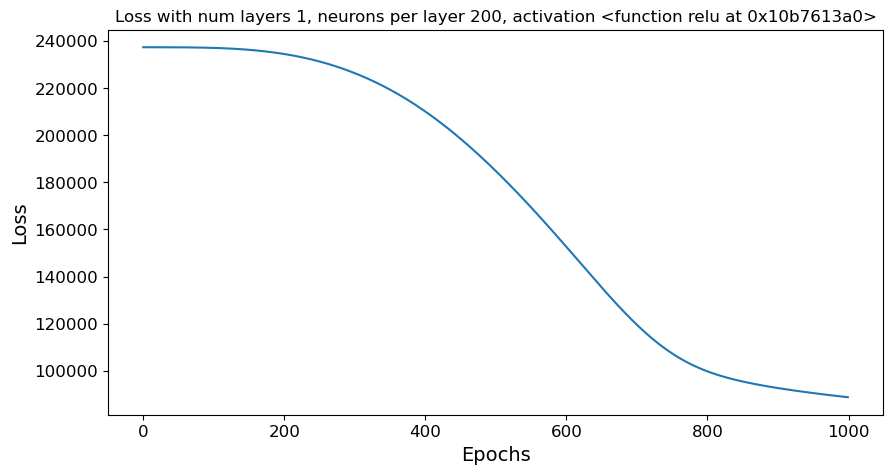

RMSE: 154816.4375 


 ##### Training the model with num layers 1, neurons per layer 200, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.484375
Epoch 100, loss 237253.75
Epoch 200, loss 237237.546875
Epoch 300, loss 237220.4375
Epoch 400, loss 237201.953125
Epoch 500, loss 237183.671875
Epoch 600, loss 237165.84375
Epoch 700, loss 237147.453125
Epoch 800, loss 237129.1875
Epoch 900, loss 237111.109375


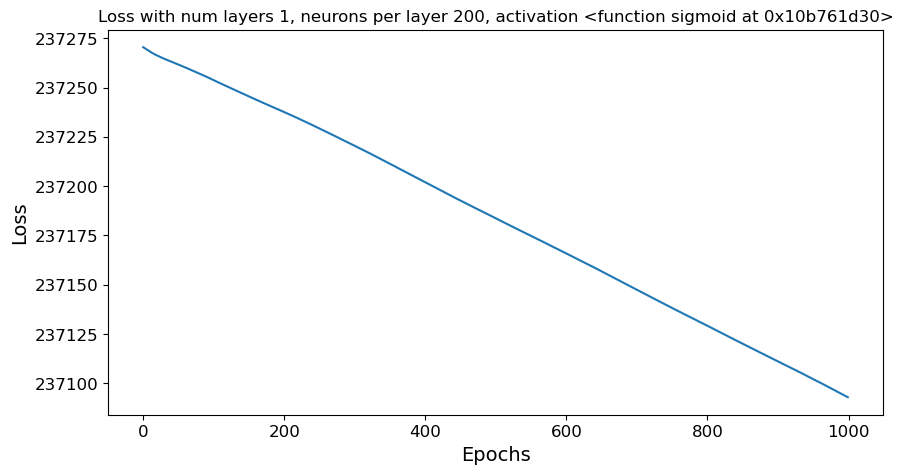

RMSE: 235054.671875 


 ##### Training the model with num layers 1, neurons per layer 200, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.859375
Epoch 100, loss 237244.421875
Epoch 200, loss 237224.328125
Epoch 300, loss 237205.515625
Epoch 400, loss 237187.15625
Epoch 500, loss 237169.0
Epoch 600, loss 237151.0
Epoch 700, loss 237133.09375
Epoch 800, loss 237115.265625
Epoch 900, loss 237097.46875


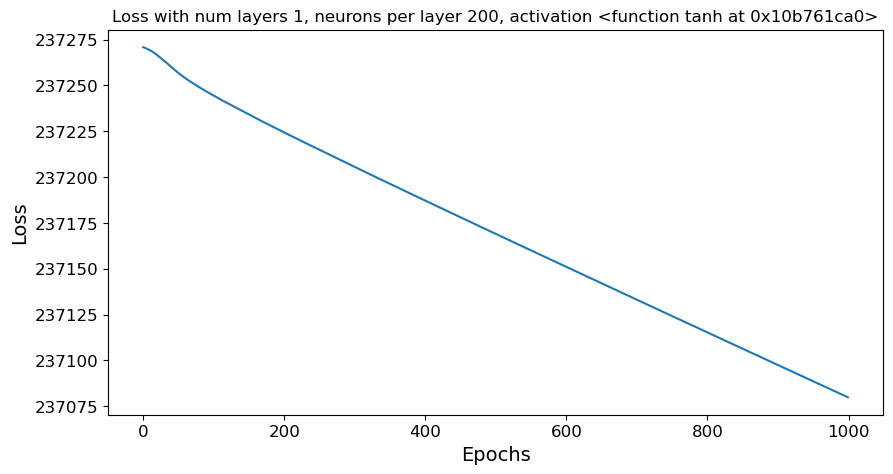

RMSE: 235041.640625 


 ##### Training the model with num layers 1, neurons per layer 300, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.6875
Epoch 100, loss 236635.5625
Epoch 200, loss 230945.953125
Epoch 300, loss 213613.859375
Epoch 400, loss 181108.578125
Epoch 500, loss 137177.234375
Epoch 600, loss 101393.6328125
Epoch 700, loss 90598.3046875
Epoch 800, loss 86071.7421875
Epoch 900, loss 82766.546875


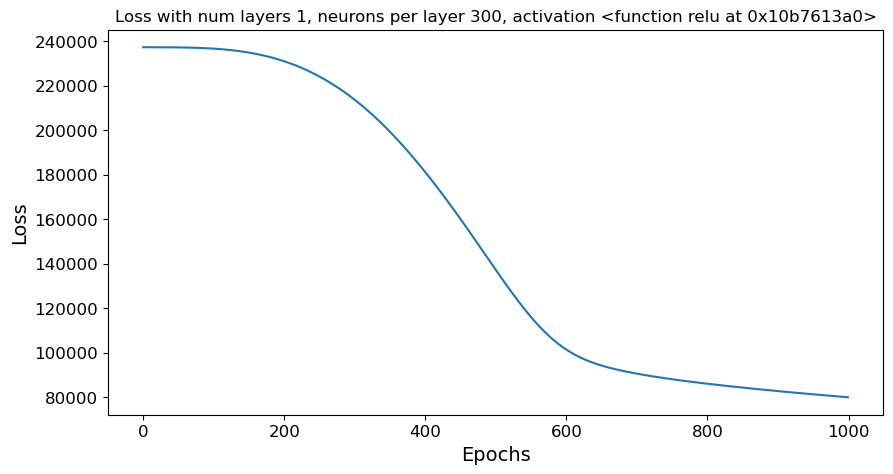

RMSE: 150176.578125 


 ##### Training the model with num layers 1, neurons per layer 300, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.53125
Epoch 100, loss 237247.515625
Epoch 200, loss 237224.625
Epoch 300, loss 237201.0625
Epoch 400, loss 237176.46875
Epoch 500, loss 237151.125
Epoch 600, loss 237125.234375
Epoch 700, loss 237099.234375
Epoch 800, loss 237073.546875
Epoch 900, loss 237047.546875


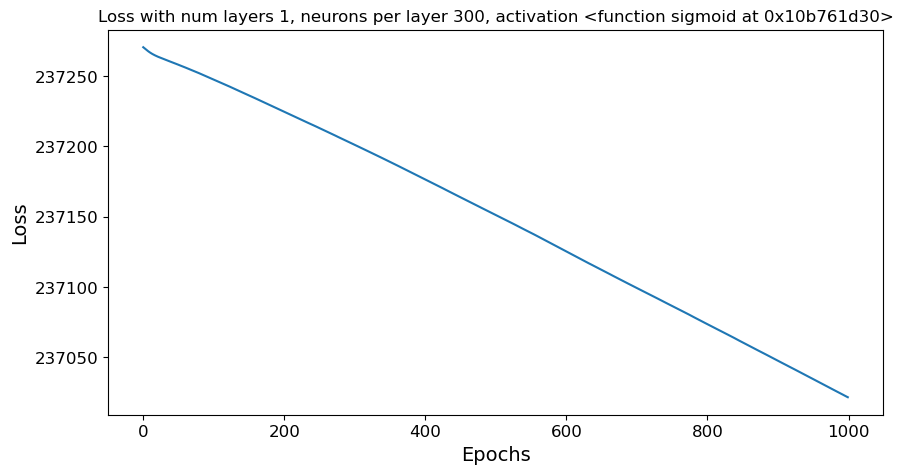

RMSE: 234983.28125 


 ##### Training the model with num layers 1, neurons per layer 300, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.65625
Epoch 100, loss 237233.453125
Epoch 200, loss 237204.578125
Epoch 300, loss 237176.96875
Epoch 400, loss 237149.796875
Epoch 500, loss 237122.890625
Epoch 600, loss 237096.125
Epoch 700, loss 237069.453125
Epoch 800, loss 237042.859375
Epoch 900, loss 237016.3125


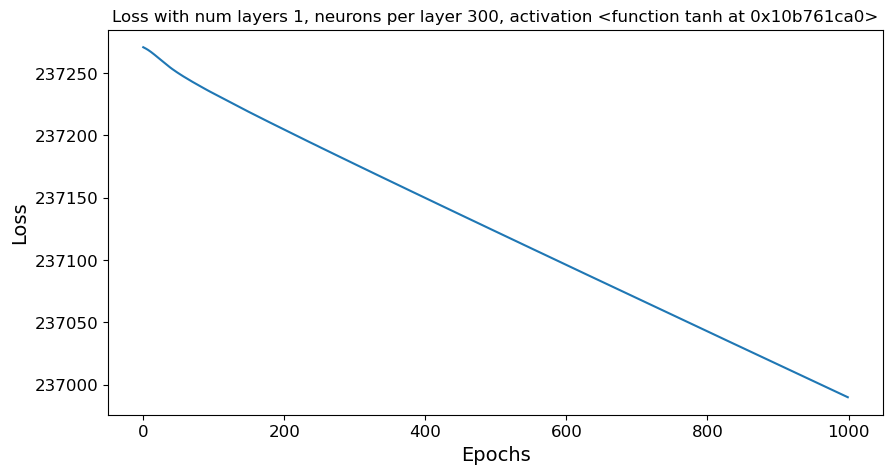

RMSE: 234951.71875 


 ##### Training the model with num layers 2, neurons per layer 50, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 237098.609375
Epoch 200, loss 232691.359375
Epoch 300, loss 207721.0625
Epoch 400, loss 145671.765625
Epoch 500, loss 101603.5625
Epoch 600, loss 91256.6171875
Epoch 700, loss 85275.6875
Epoch 800, loss 81072.6015625
Epoch 900, loss 77813.515625


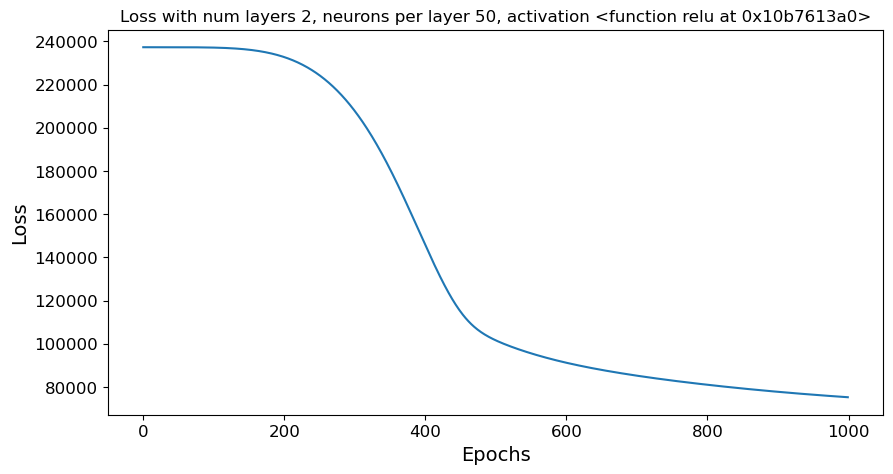

RMSE: 148501.046875 


 ##### Training the model with num layers 2, neurons per layer 50, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.203125
Epoch 100, loss 237267.125
Epoch 200, loss 237263.75
Epoch 300, loss 237260.375
Epoch 400, loss 237256.359375
Epoch 500, loss 237252.265625
Epoch 600, loss 237248.234375
Epoch 700, loss 237244.140625
Epoch 800, loss 237240.15625
Epoch 900, loss 237235.84375


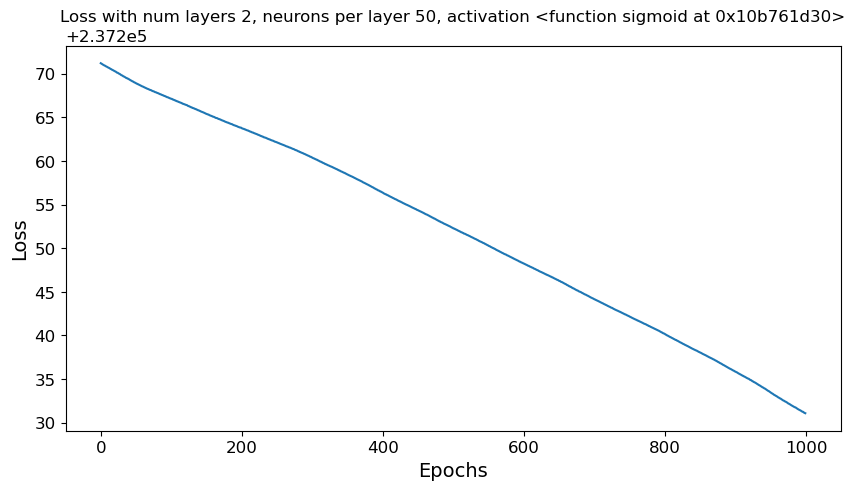

RMSE: 235193.03125 


 ##### Training the model with num layers 2, neurons per layer 50, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.890625
Epoch 100, loss 237262.625
Epoch 200, loss 237257.359375
Epoch 300, loss 237252.515625
Epoch 400, loss 237247.8125
Epoch 500, loss 237243.171875
Epoch 600, loss 237238.578125
Epoch 700, loss 237234.03125
Epoch 800, loss 237229.46875
Epoch 900, loss 237224.9375


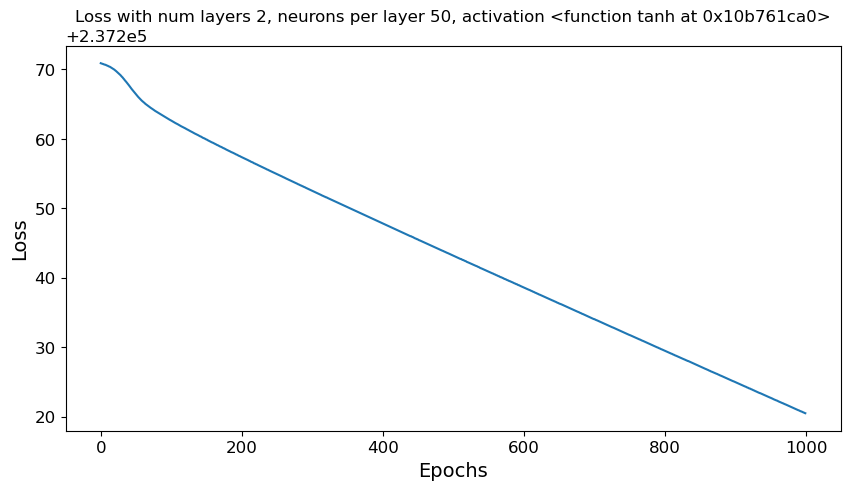

RMSE: 235182.4375 


 ##### Training the model with num layers 2, neurons per layer 100, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 236202.984375
Epoch 200, loss 208065.53125
Epoch 300, loss 106645.25
Epoch 400, loss 86340.796875
Epoch 500, loss 80390.0234375
Epoch 600, loss 76128.53125
Epoch 700, loss 73127.0390625
Epoch 800, loss 71139.109375
Epoch 900, loss 69795.4296875


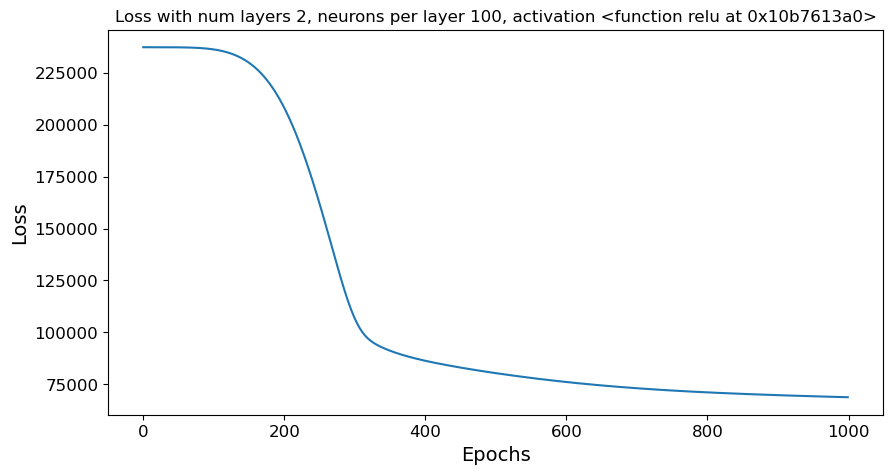

RMSE: 146737.0 


 ##### Training the model with num layers 2, neurons per layer 100, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.21875
Epoch 100, loss 237263.609375
Epoch 200, loss 237256.84375
Epoch 300, loss 237250.421875
Epoch 400, loss 237243.1875
Epoch 500, loss 237236.25
Epoch 600, loss 237229.03125
Epoch 700, loss 237221.953125
Epoch 800, loss 237214.53125
Epoch 900, loss 237206.765625


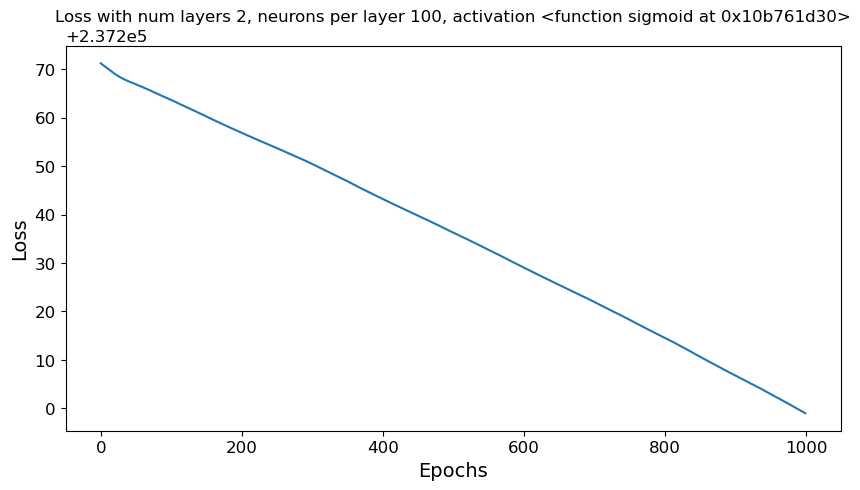

RMSE: 235160.921875 


 ##### Training the model with num layers 2, neurons per layer 100, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.890625
Epoch 100, loss 237256.421875
Epoch 200, loss 237246.671875
Epoch 300, loss 237237.40625
Epoch 400, loss 237228.296875
Epoch 500, loss 237219.265625
Epoch 600, loss 237210.28125
Epoch 700, loss 237201.296875
Epoch 800, loss 237192.375
Epoch 900, loss 237183.46875


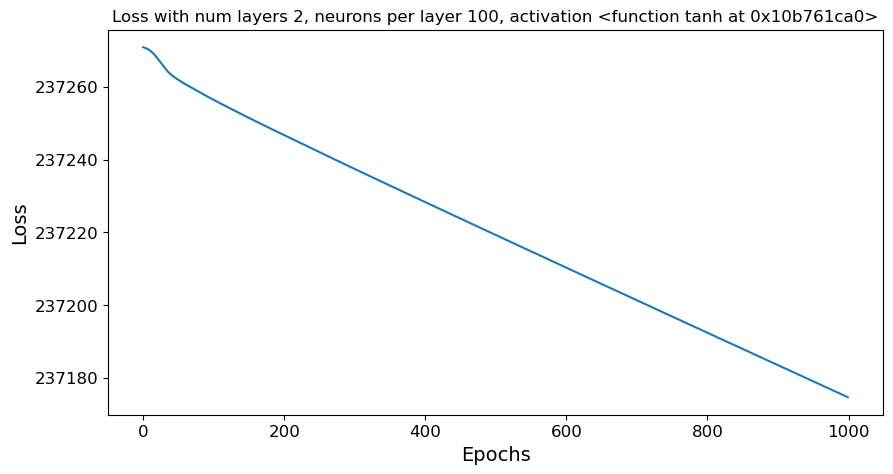

RMSE: 235136.546875 


 ##### Training the model with num layers 2, neurons per layer 200, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.6875
Epoch 100, loss 228683.21875
Epoch 200, loss 100325.0390625
Epoch 300, loss 82036.1015625
Epoch 400, loss 75163.3671875
Epoch 500, loss 71615.0234375
Epoch 600, loss 69557.484375
Epoch 700, loss 68171.4609375
Epoch 800, loss 67139.859375
Epoch 900, loss 66348.8515625


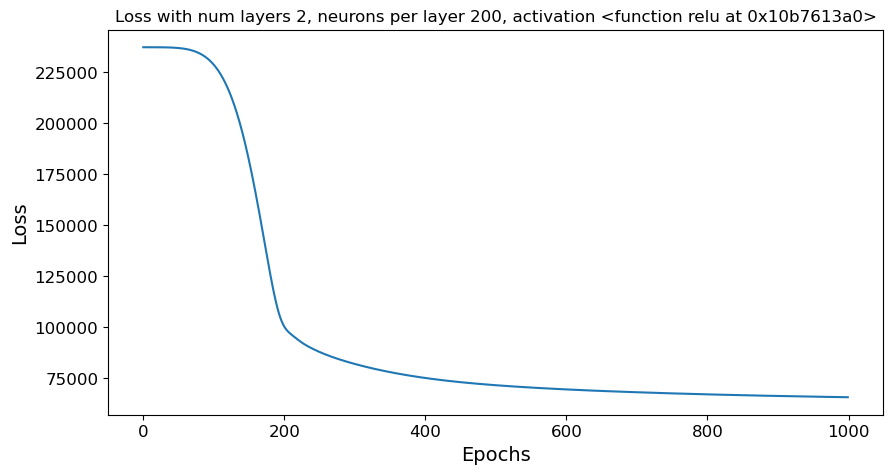

RMSE: 148300.109375 


 ##### Training the model with num layers 2, neurons per layer 200, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.34375
Epoch 100, loss 237257.140625
Epoch 200, loss 237244.5
Epoch 300, loss 237231.15625
Epoch 400, loss 237218.171875
Epoch 500, loss 237205.5625
Epoch 600, loss 237193.09375
Epoch 700, loss 237180.75
Epoch 800, loss 237168.34375
Epoch 900, loss 237155.40625


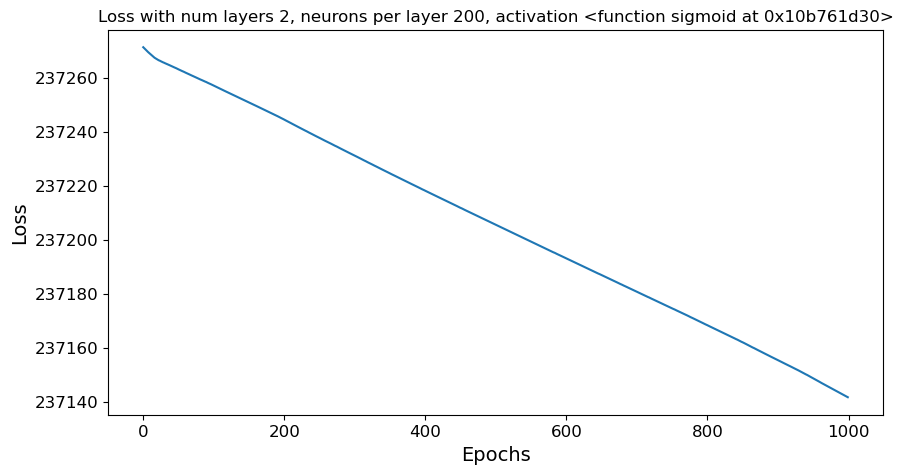

RMSE: 235103.515625 


 ##### Training the model with num layers 2, neurons per layer 200, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 237245.921875
Epoch 200, loss 237227.46875
Epoch 300, loss 237209.4375
Epoch 400, loss 237191.5625
Epoch 500, loss 237173.78125
Epoch 600, loss 237156.03125
Epoch 700, loss 237138.359375
Epoch 800, loss 237120.6875
Epoch 900, loss 237103.03125


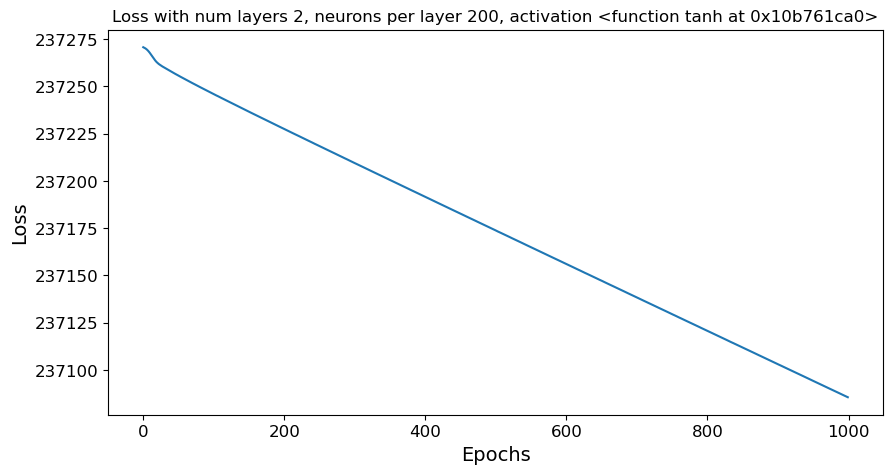

RMSE: 235047.34375 


 ##### Training the model with num layers 2, neurons per layer 300, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.765625
Epoch 100, loss 209277.0
Epoch 200, loss 87008.21875
Epoch 300, loss 75655.46875
Epoch 400, loss 71260.71875
Epoch 500, loss 68870.3046875
Epoch 600, loss 67296.0
Epoch 700, loss 66230.484375
Epoch 800, loss 65461.765625
Epoch 900, loss 64879.4453125


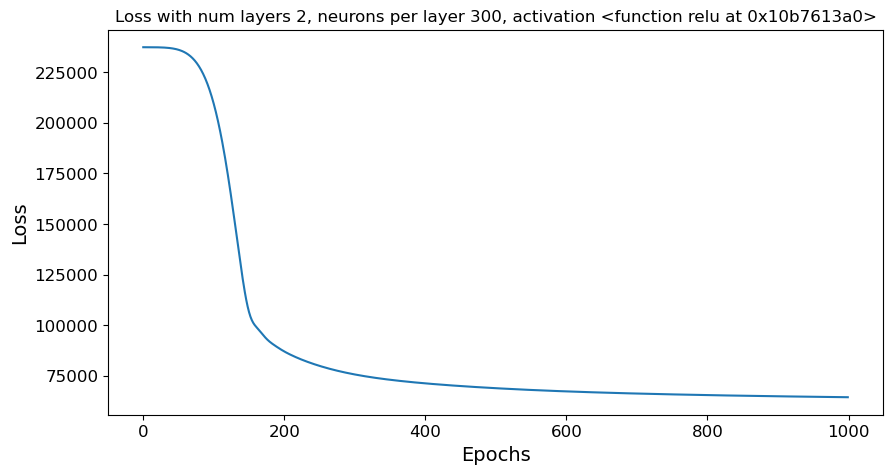

RMSE: 149255.125 


 ##### Training the model with num layers 2, neurons per layer 300, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.609375
Epoch 100, loss 237249.578125
Epoch 200, loss 237231.25
Epoch 300, loss 237212.484375
Epoch 400, loss 237193.328125
Epoch 500, loss 237173.46875
Epoch 600, loss 237153.8125
Epoch 700, loss 237133.921875
Epoch 800, loss 237113.6875
Epoch 900, loss 237092.71875


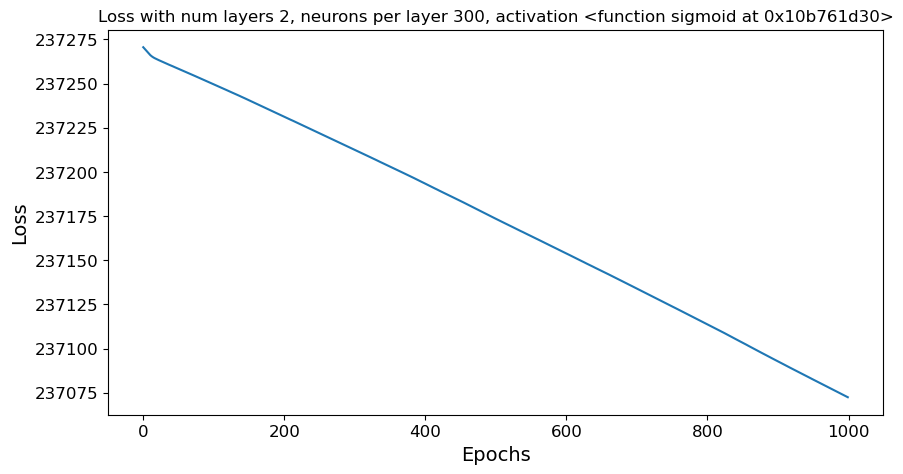

RMSE: 235034.15625 


 ##### Training the model with num layers 2, neurons per layer 300, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 237235.296875
Epoch 200, loss 237208.046875
Epoch 300, loss 237181.25
Epoch 400, loss 237154.625
Epoch 500, loss 237128.078125
Epoch 600, loss 237101.625
Epoch 700, loss 237075.203125
Epoch 800, loss 237048.78125
Epoch 900, loss 237022.40625


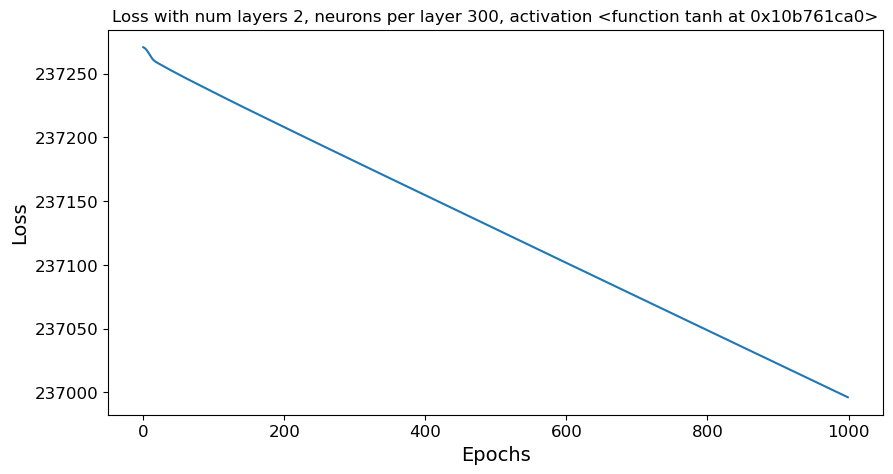

RMSE: 234957.953125 


 ##### Training the model with num layers 3, neurons per layer 50, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 236602.734375
Epoch 200, loss 187866.25
Epoch 300, loss 94248.25
Epoch 400, loss 83786.8046875
Epoch 500, loss 77219.0
Epoch 600, loss 73099.8359375
Epoch 700, loss 70744.203125
Epoch 800, loss 69211.609375
Epoch 900, loss 68135.0390625


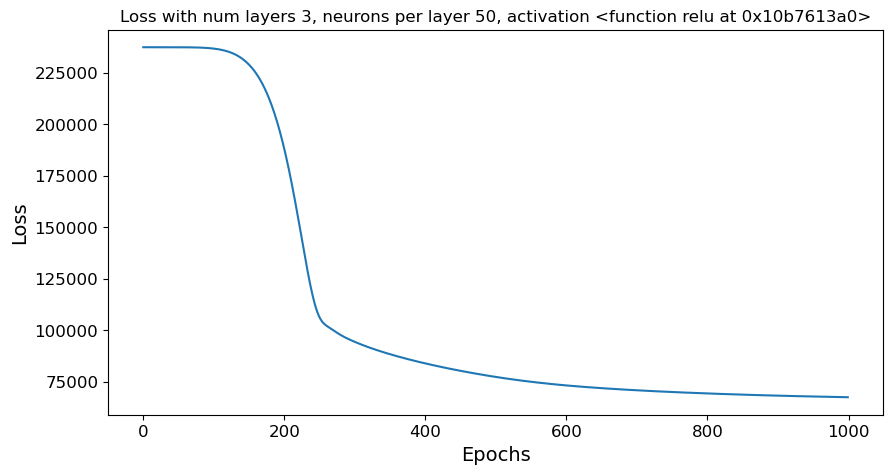

RMSE: 147335.375 


 ##### Training the model with num layers 3, neurons per layer 50, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.65625
Epoch 100, loss 237265.84375
Epoch 200, loss 237261.9375
Epoch 300, loss 237257.71875
Epoch 400, loss 237253.171875
Epoch 500, loss 237248.921875
Epoch 600, loss 237244.78125
Epoch 700, loss 237240.4375
Epoch 800, loss 237236.25
Epoch 900, loss 237232.09375


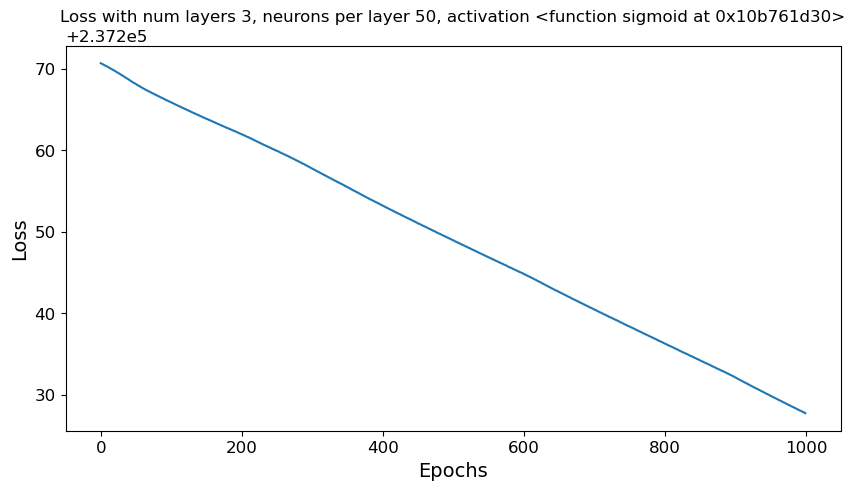

RMSE: 235189.671875 


 ##### Training the model with num layers 3, neurons per layer 50, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 237262.53125
Epoch 200, loss 237257.53125
Epoch 300, loss 237252.8125
Epoch 400, loss 237248.1875
Epoch 500, loss 237243.609375
Epoch 600, loss 237239.0625
Epoch 700, loss 237234.53125
Epoch 800, loss 237230.015625
Epoch 900, loss 237225.515625


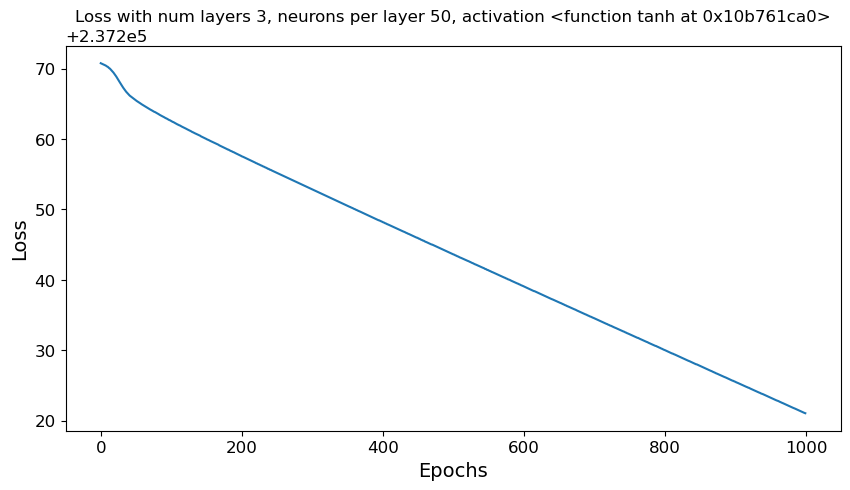

RMSE: 235183.0 


 ##### Training the model with num layers 3, neurons per layer 100, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.796875
Epoch 100, loss 223685.046875
Epoch 200, loss 87616.859375
Epoch 300, loss 75832.1484375
Epoch 400, loss 71389.203125
Epoch 500, loss 68984.84375
Epoch 600, loss 67476.8671875
Epoch 700, loss 66467.7578125
Epoch 800, loss 65726.5625
Epoch 900, loss 65174.58984375


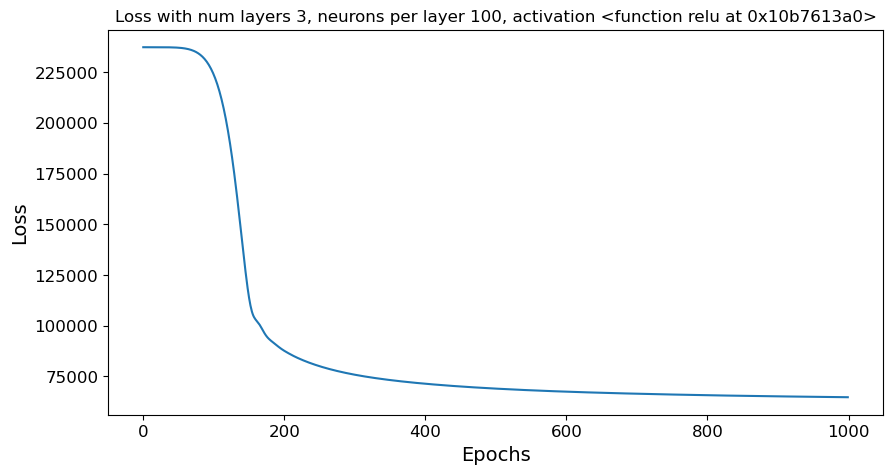

RMSE: 149093.5625 


 ##### Training the model with num layers 3, neurons per layer 100, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.046875
Epoch 100, loss 237263.6875
Epoch 200, loss 237256.25
Epoch 300, loss 237248.46875
Epoch 400, loss 237240.75
Epoch 500, loss 237232.75
Epoch 600, loss 237224.359375
Epoch 700, loss 237215.953125
Epoch 800, loss 237207.25
Epoch 900, loss 237198.65625


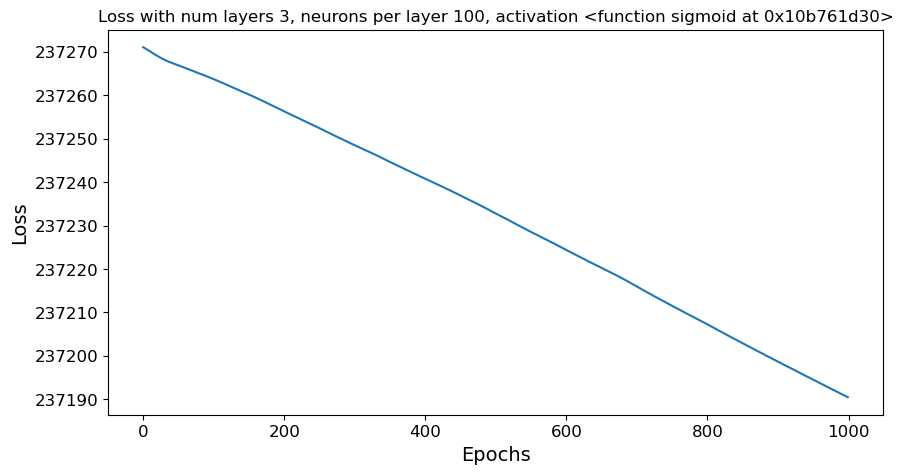

RMSE: 235152.375 


 ##### Training the model with num layers 3, neurons per layer 100, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 237257.234375
Epoch 200, loss 237247.84375
Epoch 300, loss 237238.71875
Epoch 400, loss 237229.6875
Epoch 500, loss 237220.71875
Epoch 600, loss 237211.796875
Epoch 700, loss 237202.890625
Epoch 800, loss 237193.984375
Epoch 900, loss 237185.109375


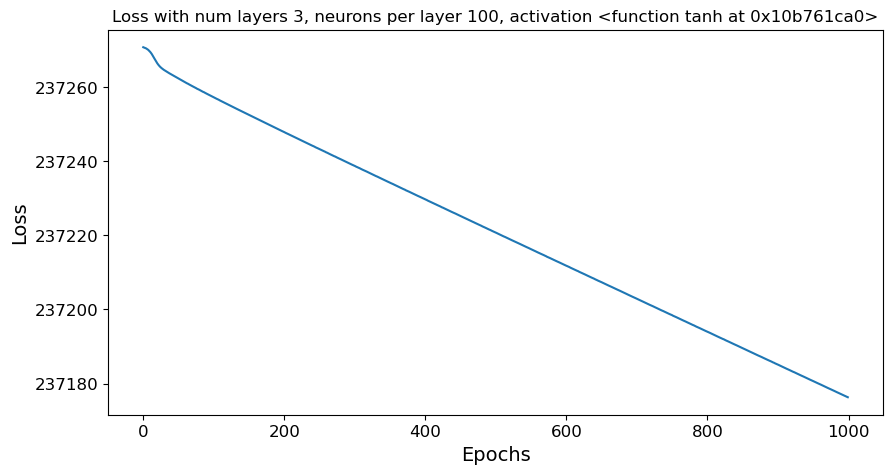

RMSE: 235138.21875 


 ##### Training the model with num layers 3, neurons per layer 200, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 117779.1171875
Epoch 200, loss 77196.671875
Epoch 300, loss 70707.140625
Epoch 400, loss 67555.8671875
Epoch 500, loss 65744.6015625
Epoch 600, loss 64482.890625
Epoch 700, loss 63370.80859375
Epoch 800, loss 61931.796875
Epoch 900, loss 59338.74609375


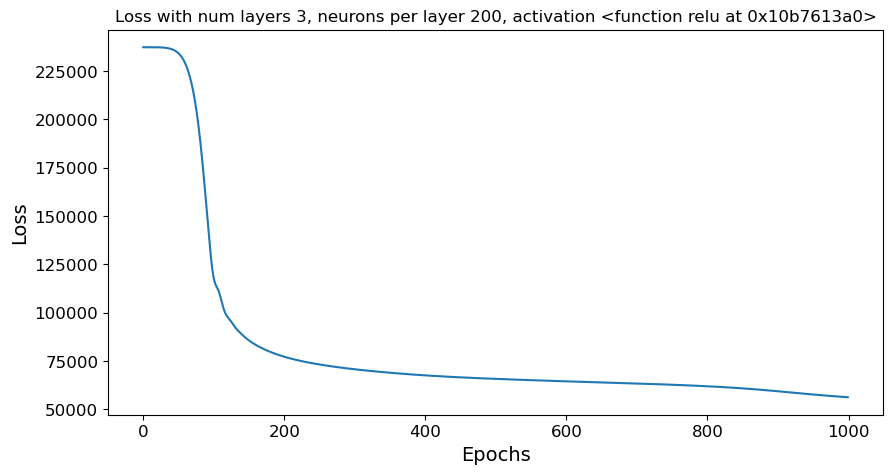

RMSE: 152163.125 


 ##### Training the model with num layers 3, neurons per layer 200, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.59375
Epoch 100, loss 237255.953125
Epoch 200, loss 237243.28125
Epoch 300, loss 237230.515625
Epoch 400, loss 237217.421875
Epoch 500, loss 237203.71875
Epoch 600, loss 237190.0
Epoch 700, loss 237176.484375
Epoch 800, loss 237162.25
Epoch 900, loss 237148.484375


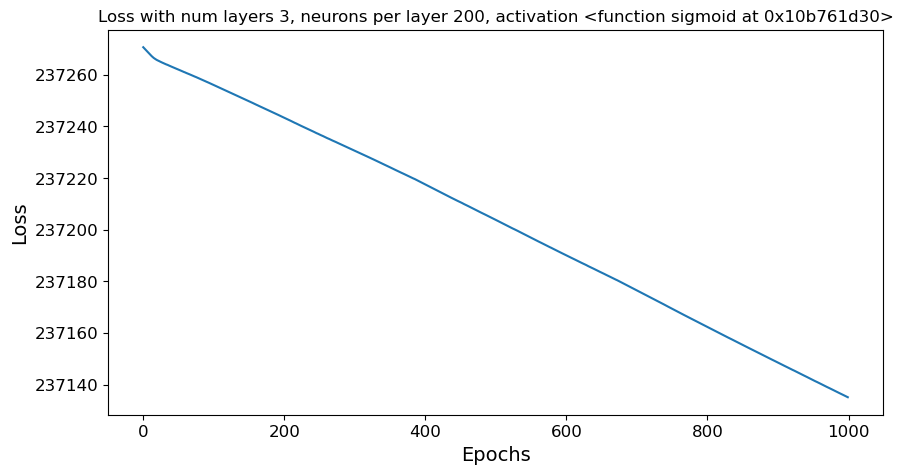

RMSE: 235096.90625 


 ##### Training the model with num layers 3, neurons per layer 200, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.796875
Epoch 100, loss 237246.390625
Epoch 200, loss 237228.1875
Epoch 300, loss 237210.296875
Epoch 400, loss 237192.5
Epoch 500, loss 237174.78125
Epoch 600, loss 237157.09375
Epoch 700, loss 237139.4375
Epoch 800, loss 237121.796875
Epoch 900, loss 237104.1875


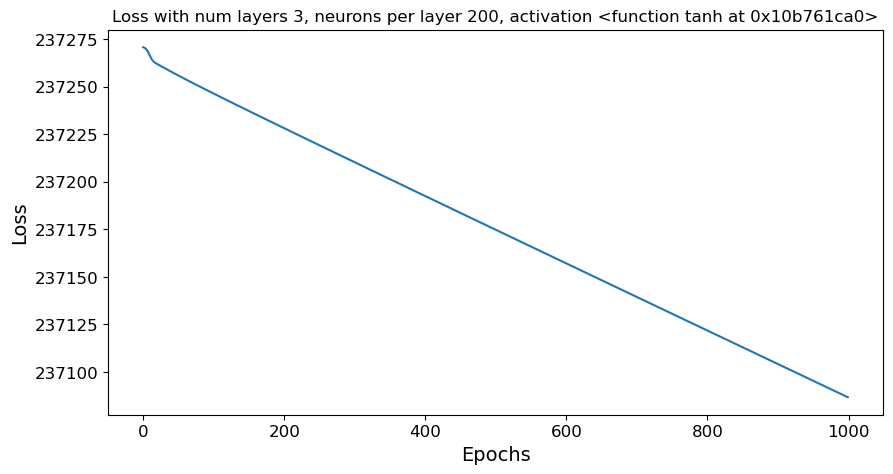

RMSE: 235048.515625 


 ##### Training the model with num layers 3, neurons per layer 300, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 93767.4609375
Epoch 200, loss 72459.9609375
Epoch 300, loss 67816.953125
Epoch 400, loss 65324.41015625
Epoch 500, loss 63489.22265625
Epoch 600, loss 61693.0546875
Epoch 700, loss 59687.13671875
Epoch 800, loss 57656.9921875
Epoch 900, loss 55980.6171875


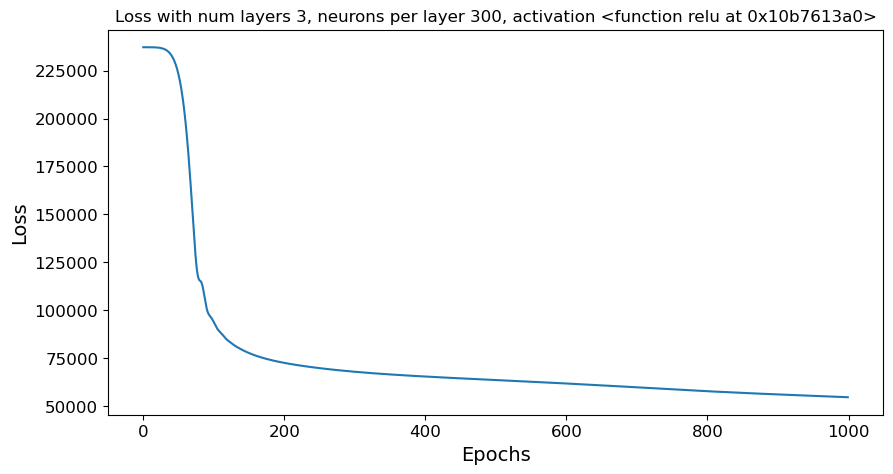

RMSE: 152528.015625 


 ##### Training the model with num layers 3, neurons per layer 300, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.53125
Epoch 100, loss 237249.28125
Epoch 200, loss 237230.71875
Epoch 300, loss 237211.796875
Epoch 400, loss 237192.5625
Epoch 500, loss 237173.765625
Epoch 600, loss 237154.671875
Epoch 700, loss 237135.328125
Epoch 800, loss 237115.65625
Epoch 900, loss 237096.125


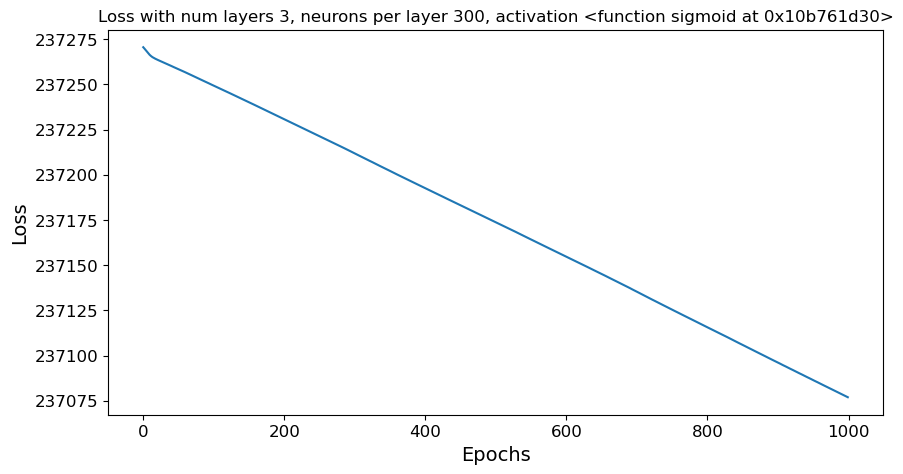

RMSE: 235038.71875 


 ##### Training the model with num layers 3, neurons per layer 300, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.8125
Epoch 100, loss 237236.5625
Epoch 200, loss 237209.578125
Epoch 300, loss 237182.921875
Epoch 400, loss 237156.359375
Epoch 500, loss 237129.921875
Epoch 600, loss 237103.484375
Epoch 700, loss 237077.09375
Epoch 800, loss 237050.71875
Epoch 900, loss 237024.375


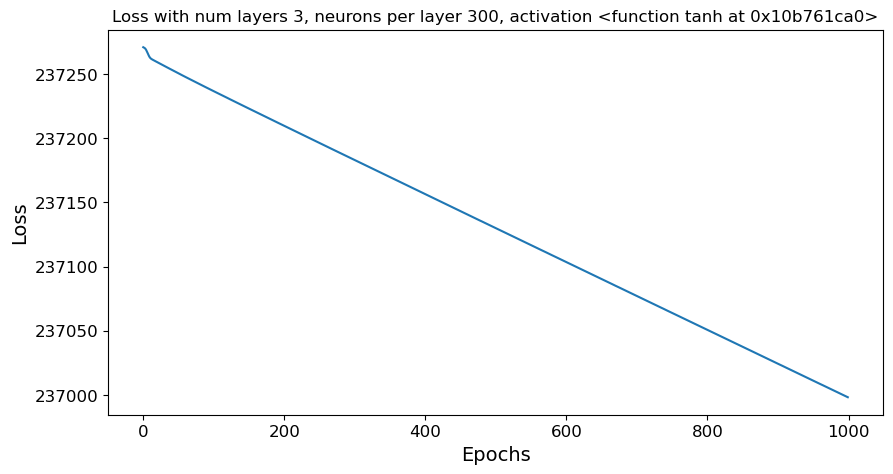

RMSE: 234959.9375 


 ##### Training the model with num layers 4, neurons per layer 50, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.75
Epoch 100, loss 233357.953125
Epoch 200, loss 91350.0546875
Epoch 300, loss 77628.203125
Epoch 400, loss 72689.4140625
Epoch 500, loss 70156.0625
Epoch 600, loss 68328.96875
Epoch 700, loss 66947.265625
Epoch 800, loss 65913.6015625
Epoch 900, loss 65146.37890625


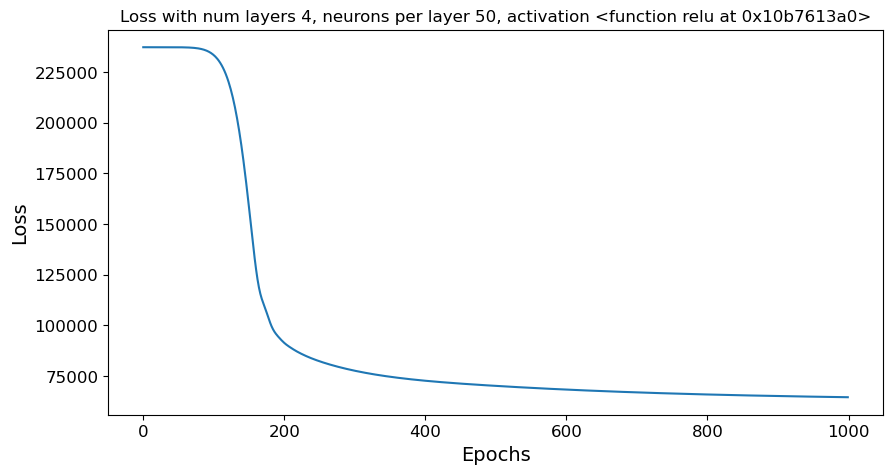

RMSE: 149292.828125 


 ##### Training the model with num layers 4, neurons per layer 50, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.828125
Epoch 100, loss 237266.296875
Epoch 200, loss 237262.796875
Epoch 300, loss 237258.828125
Epoch 400, loss 237254.796875
Epoch 500, loss 237250.390625
Epoch 600, loss 237245.96875
Epoch 700, loss 237241.625
Epoch 800, loss 237237.15625
Epoch 900, loss 237232.71875


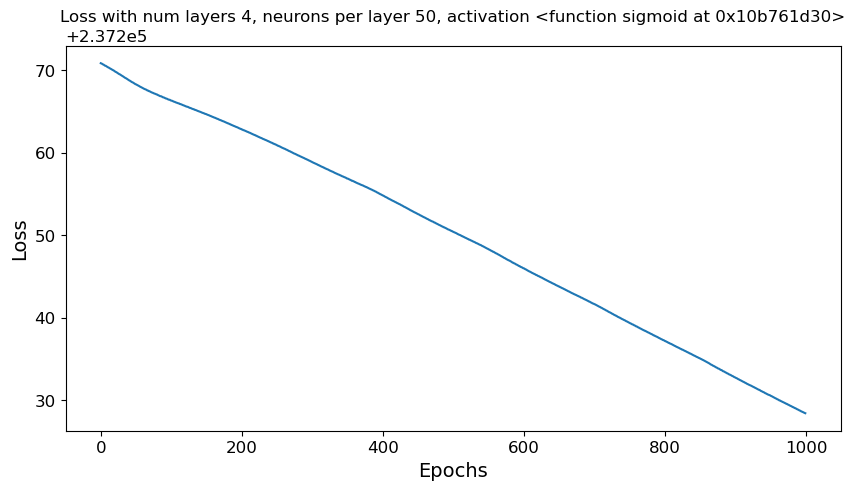

RMSE: 235190.34375 


 ##### Training the model with num layers 4, neurons per layer 50, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.65625
Epoch 100, loss 237263.09375
Epoch 200, loss 237258.140625
Epoch 300, loss 237253.421875
Epoch 400, loss 237248.78125
Epoch 500, loss 237244.203125
Epoch 600, loss 237239.671875
Epoch 700, loss 237235.140625
Epoch 800, loss 237230.625
Epoch 900, loss 237226.109375


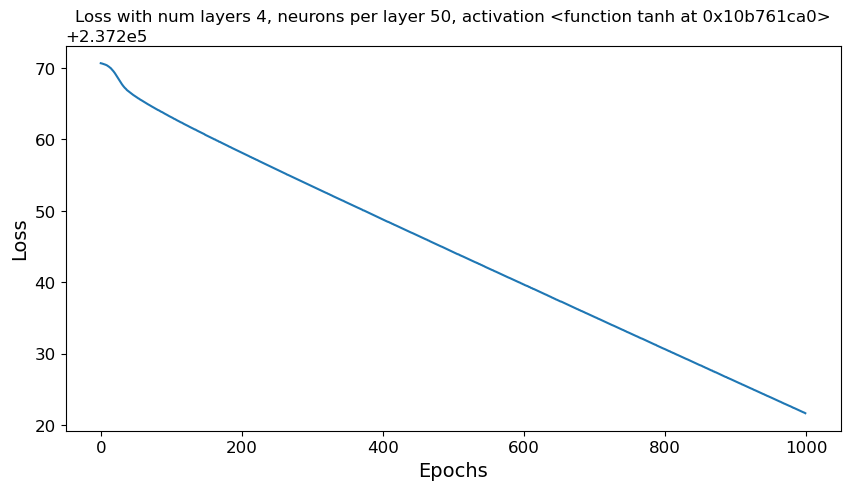

RMSE: 235183.625 


 ##### Training the model with num layers 4, neurons per layer 100, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.859375
Epoch 100, loss 140859.984375
Epoch 200, loss 79425.703125
Epoch 300, loss 71758.84375
Epoch 400, loss 68136.7265625
Epoch 500, loss 65928.4453125
Epoch 600, loss 64313.05078125
Epoch 700, loss 62935.94140625
Epoch 800, loss 61510.19140625
Epoch 900, loss 60139.73828125


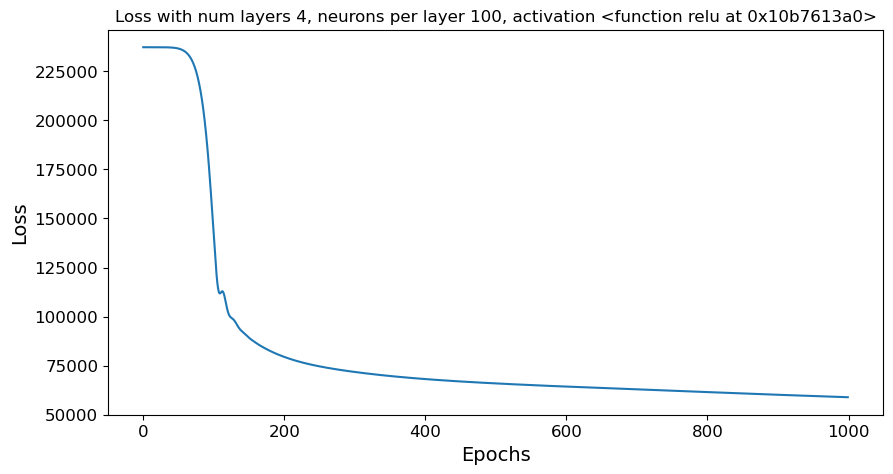

RMSE: 151082.109375 


 ##### Training the model with num layers 4, neurons per layer 100, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.375
Epoch 100, loss 237261.75
Epoch 200, loss 237254.03125
Epoch 300, loss 237245.953125
Epoch 400, loss 237237.40625
Epoch 500, loss 237229.109375
Epoch 600, loss 237221.109375
Epoch 700, loss 237213.09375
Epoch 800, loss 237204.90625
Epoch 900, loss 237196.75


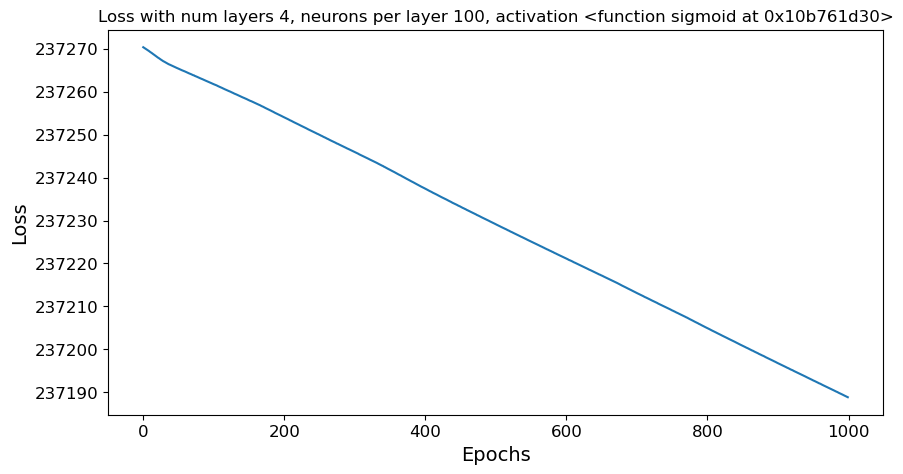

RMSE: 235150.734375 


 ##### Training the model with num layers 4, neurons per layer 100, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.640625
Epoch 100, loss 237256.8125
Epoch 200, loss 237247.453125
Epoch 300, loss 237238.359375
Epoch 400, loss 237229.359375
Epoch 500, loss 237220.421875
Epoch 600, loss 237211.484375
Epoch 700, loss 237202.578125
Epoch 800, loss 237193.6875
Epoch 900, loss 237184.8125


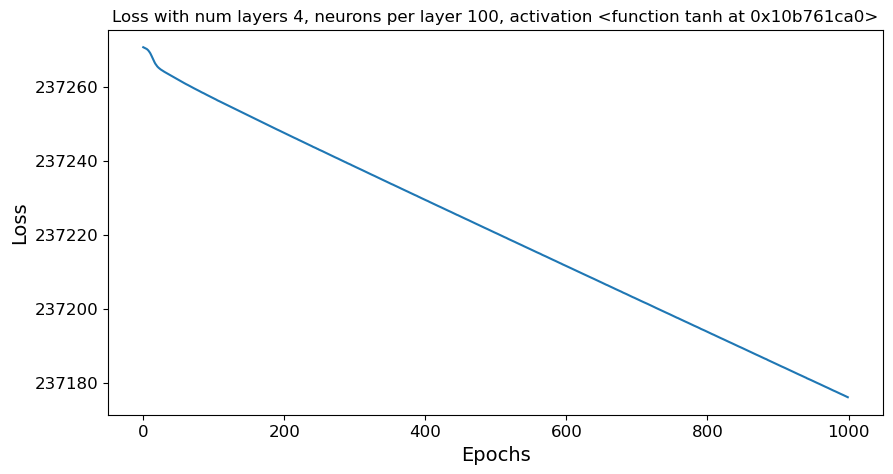

RMSE: 235137.9375 


 ##### Training the model with num layers 4, neurons per layer 200, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.796875
Epoch 100, loss 89578.0234375
Epoch 200, loss 71102.0703125
Epoch 300, loss 66680.1796875
Epoch 400, loss 64565.2890625
Epoch 500, loss 62857.3671875
Epoch 600, loss 60818.9609375
Epoch 700, loss 57874.078125
Epoch 800, loss 54938.76953125
Epoch 900, loss 52730.31640625


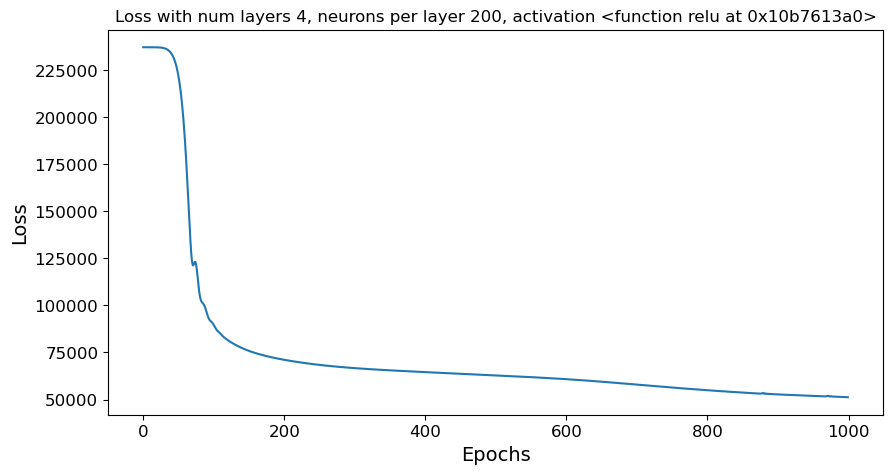

RMSE: 153325.3125 


 ##### Training the model with num layers 4, neurons per layer 200, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237270.6875
Epoch 100, loss 237255.265625
Epoch 200, loss 237241.984375
Epoch 300, loss 237228.203125
Epoch 400, loss 237214.40625
Epoch 500, loss 237200.59375
Epoch 600, loss 237185.953125
Epoch 700, loss 237171.625
Epoch 800, loss 237157.078125
Epoch 900, loss 237142.578125


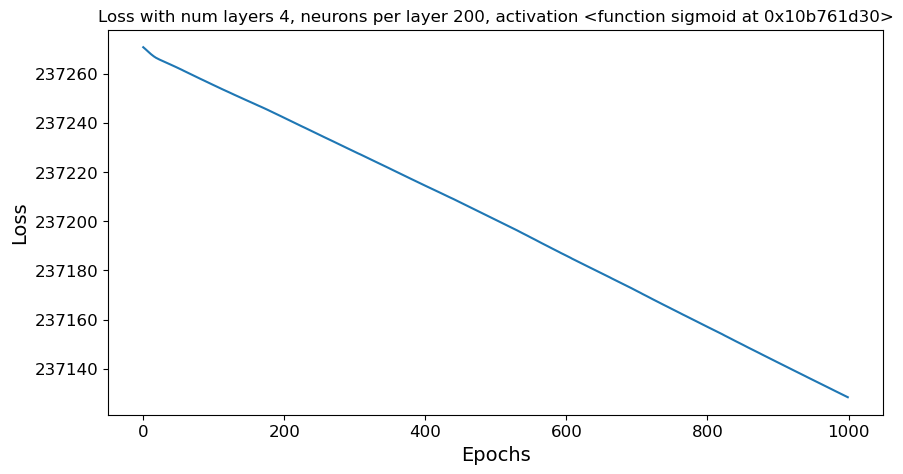

RMSE: 235090.296875 


 ##### Training the model with num layers 4, neurons per layer 200, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.859375
Epoch 100, loss 237246.703125
Epoch 200, loss 237228.59375
Epoch 300, loss 237210.75
Epoch 400, loss 237193.0
Epoch 500, loss 237175.296875
Epoch 600, loss 237157.640625
Epoch 700, loss 237140.03125
Epoch 800, loss 237122.40625
Epoch 900, loss 237104.796875


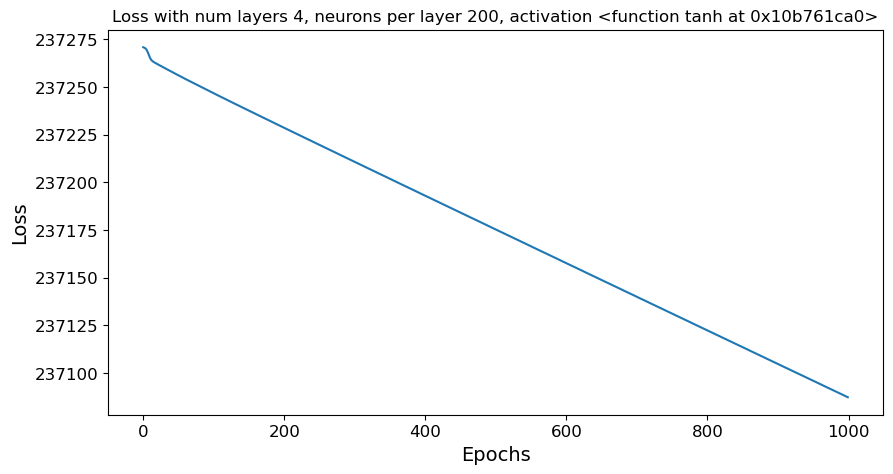

RMSE: 235049.109375 


 ##### Training the model with num layers 4, neurons per layer 300, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 81859.6875
Epoch 200, loss 68166.65625
Epoch 300, loss 63396.3359375
Epoch 400, loss 60255.546875
Epoch 500, loss 57429.6640625
Epoch 600, loss 54766.9453125
Epoch 700, loss 52234.1796875
Epoch 800, loss 50509.3203125
Epoch 900, loss 49478.390625


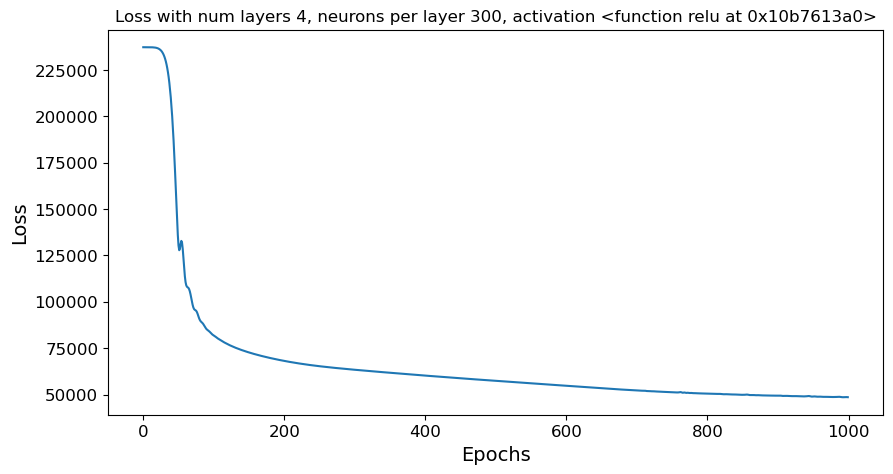

RMSE: 155218.265625 


 ##### Training the model with num layers 4, neurons per layer 300, activation <function sigmoid at 0x10b761d30> #####
Epoch 0, loss 237271.25
Epoch 100, loss 237251.5
Epoch 200, loss 237233.984375
Epoch 300, loss 237215.171875
Epoch 400, loss 237196.796875
Epoch 500, loss 237177.890625
Epoch 600, loss 237159.078125
Epoch 700, loss 237139.578125
Epoch 800, loss 237119.9375
Epoch 900, loss 237100.625


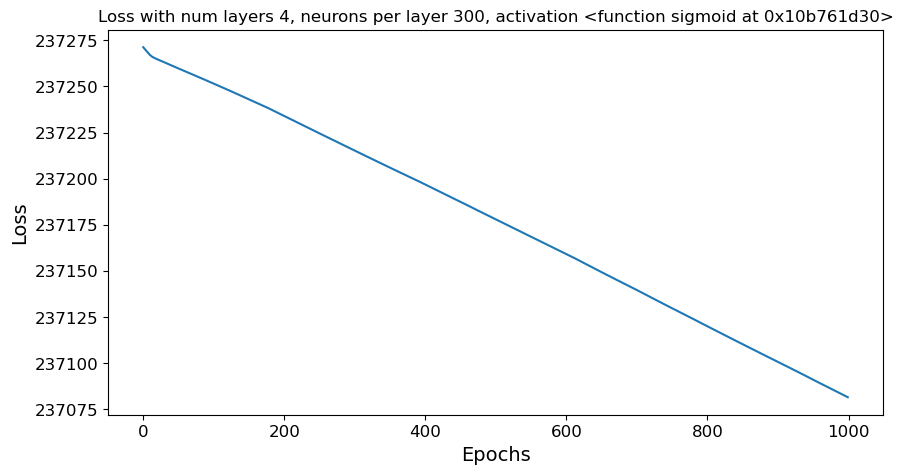

RMSE: 235043.25 


 ##### Training the model with num layers 4, neurons per layer 300, activation <function tanh at 0x10b761ca0> #####
Epoch 0, loss 237270.890625
Epoch 100, loss 237236.875
Epoch 200, loss 237209.96875
Epoch 300, loss 237183.359375
Epoch 400, loss 237156.84375
Epoch 500, loss 237130.40625
Epoch 600, loss 237104.0
Epoch 700, loss 237077.625
Epoch 800, loss 237051.25
Epoch 900, loss 237024.921875


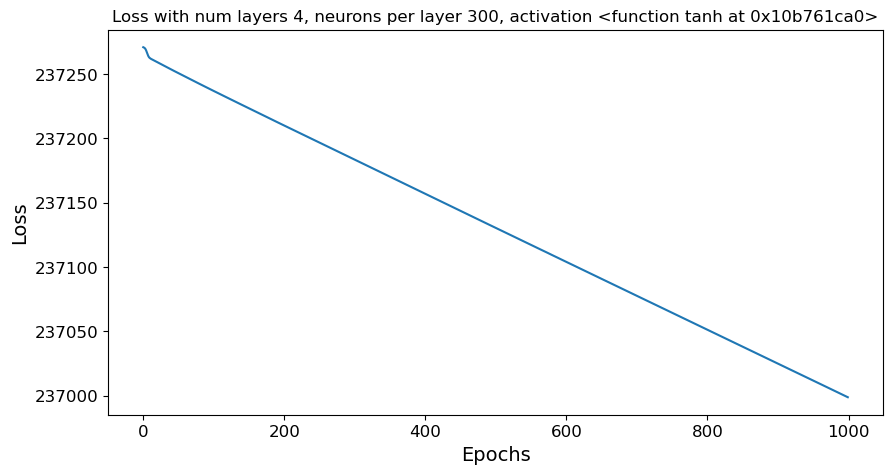

RMSE: 234960.5 


Hyperparameters: (2, 100, <function relu at 0x10b7613a0>), RMSE: 146737.0
Hyperparameters: (3, 50, <function relu at 0x10b7613a0>), RMSE: 147335.375
Hyperparameters: (2, 200, <function relu at 0x10b7613a0>), RMSE: 148300.109375
Hyperparameters: (2, 50, <function relu at 0x10b7613a0>), RMSE: 148501.046875
Hyperparameters: (3, 100, <function relu at 0x10b7613a0>), RMSE: 149093.5625
Hyperparameters: (2, 300, <function relu at 0x10b7613a0>), RMSE: 149255.125
Hyperparameters: (4, 50, <function relu at 0x10b7613a0>), RMSE: 149292.828125
Hyperparameters: (1, 300, <function relu at 0x10b7613a0>), RMSE: 150176.578125
Hyperparameters: (4, 100, <function relu at 0x10b7613a0>), RMSE: 151082.109375
Hyperparameters: (3, 200, <function relu at 0x10b7613a0>), RMSE: 152163.125
Hyperparameters: (3, 300, <function relu at 0x10b7613a0>), RMSE: 152528.015625
Hyperparameters: (4, 200, <function relu at 0x10b7613a0>), RMSE: 153325.3125
Hyperparameters: (1, 200, <function relu at 0x10b7613a0

In [33]:
#we now try to find the best hyperparameters for the model
#we define the hyperparameters we want to test with GridSearch

hidden_layers = [1, 2, 3, 4]
neurons_per_layer = [50, 100, 200, 300]
activations = [F.relu, F.sigmoid, F.tanh]
epochs = 1000
lr = 0.001

#we loop over all the hyperparameters and train the model and save the evaluation 
# metric inside a dictionary
results = {}
for hidden_layer in hidden_layers:
    for neuron_per_layer in neurons_per_layer:
        for activation in activations:
            model = MLP(input_size, output_size, hidden_layer, neuron_per_layer, activation)
            train(model, X_train_tensor, y_train_tensor, epochs, lr)
            results[(hidden_layer, neuron_per_layer, activation)] = evaluate(model, X_test_tensor, y_test_tensor)

#print the ranking of the hyperparameters
sorted_results = sorted(results.items(), key=lambda x: x[1])
for key, value in sorted_results:
    print(f'Hyperparameters: {key}, RMSE: {value}')


This result shows that (at least for this amount of epochs and this optimizer) the ReLu function
and a mid-sized network seem to provide the best results on the test set. On the other side, small
networks trained with a sigmoid activation struggle to learn the patterns in the data

 ##### Training the model with num layers 2, neurons per layer 100, activation <function relu at 0x10b7613a0> #####
Epoch 0, loss 237270.734375
Epoch 100, loss 236258.90625
Epoch 200, loss 212676.171875
Epoch 300, loss 130662.609375
Epoch 400, loss 100654.9375
Epoch 500, loss 91017.3046875
Epoch 600, loss 83998.921875
Epoch 700, loss 78350.328125
Epoch 800, loss 73918.015625
Epoch 900, loss 70869.7890625
Epoch 1000, loss 68943.3046875
Epoch 1100, loss 67761.453125
Epoch 1200, loss 67010.3515625
Epoch 1300, loss 66543.3828125
Epoch 1400, loss 66212.2734375
Epoch 1500, loss 65940.5078125
Epoch 1600, loss 65702.9453125
Epoch 1700, loss 65489.97265625
Epoch 1800, loss 65296.703125
Epoch 1900, loss 65116.41796875
Epoch 2000, loss 64936.09765625
Epoch 2100, loss 64759.0546875
Epoch 2200, loss 64580.6875
Epoch 2300, loss 64390.8515625
Epoch 2400, loss 64185.09765625
Epoch 2500, loss 63967.7421875
Epoch 2600, loss 63733.9453125
Epoch 2700, loss 63488.9453125
Epoch 2800, loss 63232.53125
Epoch 

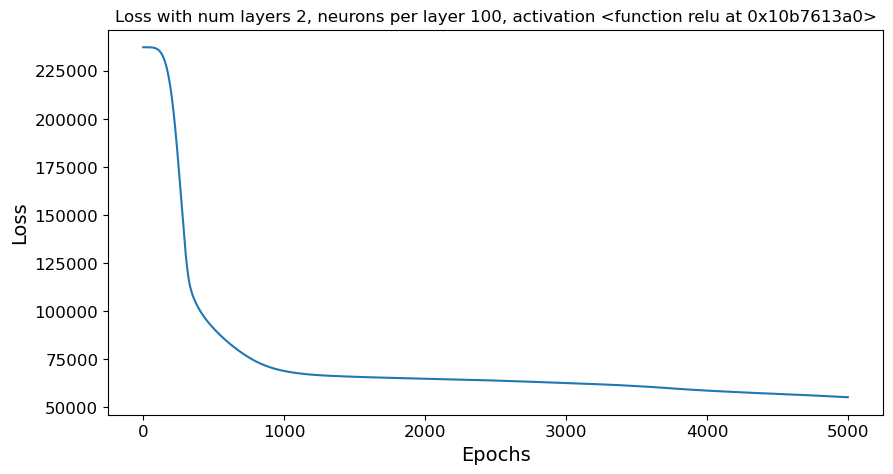

RMSE: 56464.15234375 




56464.15234375

In [83]:
# I define the model parameters and we train for longer
input_size = X_train_tensor.shape[1]
output_size = 1
hidden_layers = 2
neurons_per_layer = 100
activation = F.relu
epochs = 5000
lr = 0.001

# I train the model
model = MLP(input_size, output_size, hidden_layers, neurons_per_layer, activation)
train(model, X_train_tensor, y_train_tensor, epochs, lr)

# I evaluate the model
evaluate(model, X_test_tensor, y_test_tensor)